In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial import cKDTree
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split


In [3]:
# load data
burn_areas = gpd.read_file('fire-ignitions/campania/campania_burn_areas_2007_2021.shp')
static = gpd.read_file('static-predictors/static_predictors.shp')
# load event_df
event_df = pd.read_csv('event_data_2007_2020_final1.csv')
event_df = event_df.dropna()
event_df['geometry'] = event_df['geometry'].apply(loads)
event_df["humidity"] = pd.to_numeric(event_df["humidity"], errors="coerce")


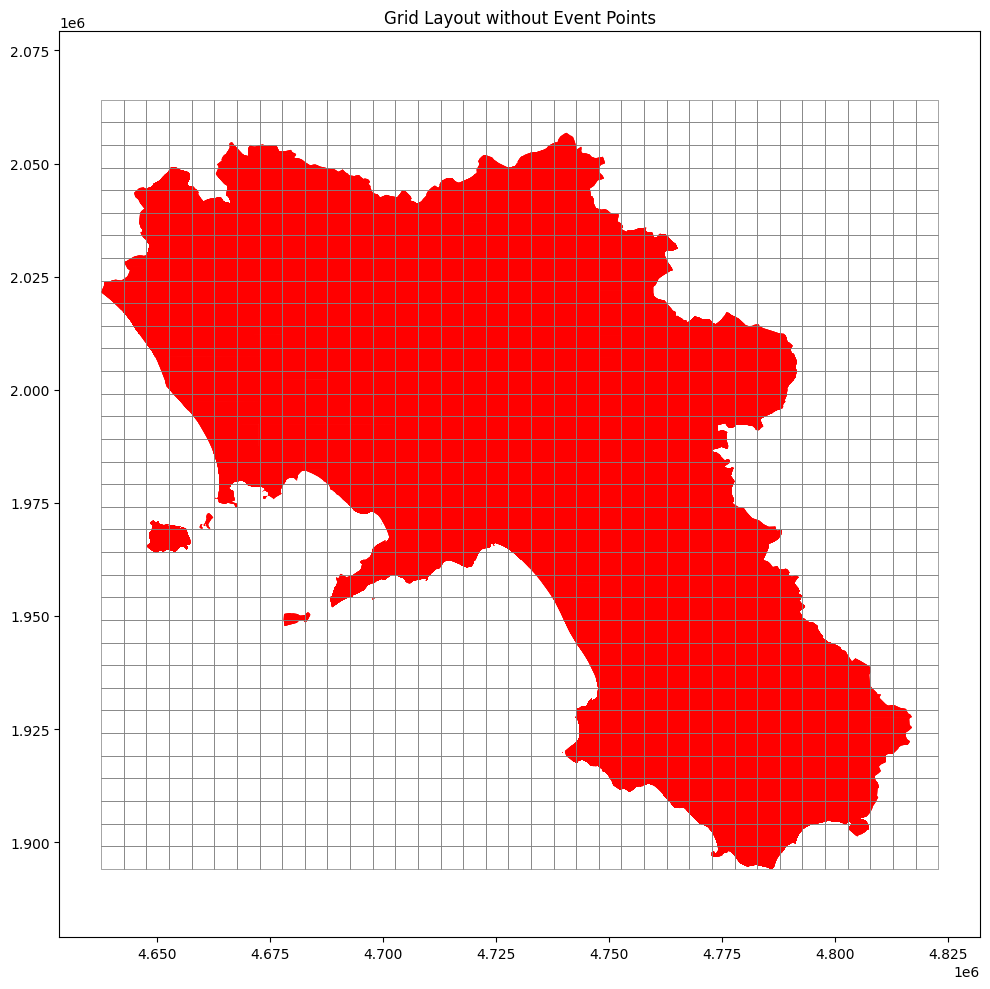

In [10]:
# import geopandas as gpd
# import numpy as np
# from shapely.geometry import box
# import matplotlib.pyplot as plt

# # Step 1: Convert to GeoDataFrame and project
# gdf = gpd.GeoDataFrame(event_df.copy(), geometry='geometry', crs="EPSG:23032")
# gdf = gdf.to_crs(epsg=3035)

# # Step 2: Create grid (e.g., 10 km)
# grid_size = 5000  # meters
# xmin, ymin, xmax, ymax = gdf.total_bounds
# cols = np.arange(xmin, xmax + grid_size, grid_size)
# rows = np.arange(ymin, ymax + grid_size, grid_size)
# grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
# grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

# # Step 3: Use centroids only for joining
# gdf_centroids = gdf.copy()
# gdf_centroids["centroid"] = gdf_centroids.geometry.centroid
# gdf_centroids = gdf_centroids.set_geometry("centroid")

# # Step 4: Spatial join for grid ID
# joined = gpd.sjoin(gdf_centroids, grid, how="left", predicate="within")
# gdf["grid_id"] = joined["index_right"]

# # Step 5: Plot original geometries (not centroids!)
# fig, ax = plt.subplots(figsize=(10, 10))
# grid.boundary.plot(ax=ax, linewidth=0.5, color='gray')
# gdf.geometry.plot(ax=ax, color='red', markersize=2)
# plt.title("Grid Layout without Event Points")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()


C:\Users\hclt0\AppData\Local\Temp\ipykernel_4684\3164581098.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(frameon=False)
C:\Users\hclt0\AppData\Local\Temp\ipykernel_4684\3164581098.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


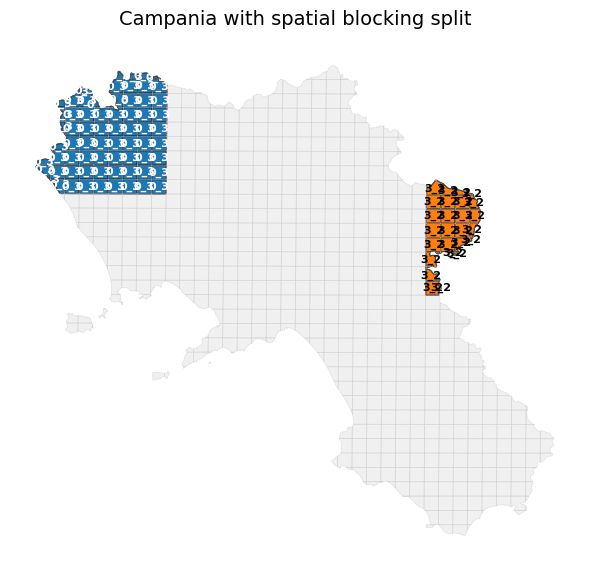

In [45]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.ops import unary_union

# # 1) Project your event_df and keep every cell polygon
# gdf = (
#     gpd.GeoDataFrame(event_df.copy(), geometry="geometry", crs="EPSG:23032")
#        .to_crs(epsg=3035)
# )

# # 2) Choose your two blocks
# A, B = "0_3", "3_2"

# # 3) Subset all cell‐polygons in those blocks
# cells_A = gdf[gdf["spatial_block"] == A].drop_duplicates(subset="id")
# cells_B = gdf[gdf["spatial_block"] == B].drop_duplicates(subset="id")

# # 4) Get a light‐grey outline of full Campania (for context)
# all_cells = gdf.drop_duplicates(subset="id")
# campania_outline = gpd.GeoSeries([unary_union(all_cells.geometry)], crs=all_cells.crs)

# # 5) Plot
# fig, ax = plt.subplots(1, 1, figsize=(6, 8))

# # full outline
# campania_outline.plot(ax=ax, facecolor="#f0f0f0", edgecolor="none")

# # all 5×5 km cells as a faint grid
# all_cells.geometry.boundary.plot(ax=ax, color="#cccccc", linewidth=0.5, alpha=0.5)

# # highlight every cell in block A
# cells_A.plot(ax=ax, facecolor="#1f77b4", edgecolor="black", linewidth=0.8, label=f"{A} ({len(cells_A)} cells)")

# # highlight every cell in block B
# cells_B.plot(ax=ax, facecolor="#ff7f0e", edgecolor="black", linewidth=0.8, label=f"{B} ({len(cells_B)} cells)")

# # centroids for labels
# for df, color in [(cells_A, "white"), (cells_B, "black")]:
#     for _, row in df.iterrows():
#         pt = row.geometry.centroid
#         ax.text(pt.x, pt.y, row["spatial_block"], ha="center", va="center",
#                 fontsize=8, fontweight="bold", color=color)

# # styling
# ax.set_title("Campania with spatial blocking split", fontsize=14, pad=12)
# ax.set_axis_off()
# ax.legend(frameon=False)

# plt.tight_layout()
# plt.show()


In [4]:
df_monthly = pd.read_csv('df_summary_monthly.csv')
df_overall = pd.read_csv('df_summary_overall.csv')

## Here i fix an issue in handeling the no prior fire i chose to omit, this is still used for logic later on, so still should be run

In [5]:
event_df = event_df.sort_values(["id", "start_time"]).copy()

def fix_no_prior_fire(group):
    """
    For each grid (group), the first row is set to no_prior_fire=1.
    If we have already seen a fire in earlier rows, then no_prior_fire=0 for subsequent rows.
    """
    has_seen_fire = False
    for i in group.index:
        if i == group.index[0]:
            # first row in this grid
            group.loc[i, "no_prior_fire"] = 1
        else:
            # subsequent rows
            group.loc[i, "no_prior_fire"] = 0 if has_seen_fire else 1

        # If this row has a fire, update flag
        if group.loc[i, "fire_occurred_x"] == 1:
            has_seen_fire = True
    return group

# Apply the logic per grid (grouped by 'id')
event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)

# (Optional) re-sort or reset index if you wish
event_df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

C:\Users\hclt0\AppData\Local\Temp\ipykernel_14556\4029580595.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


## Again we resolve an issue in the dataframe regarding days since fire, no prior fire etc, this should also be run

In [6]:
import numpy as np
import pandas as pd

# ────────────────────────────────────────────────────────────────
# 0) Ensure you have the fire flag and no_prior_fire up-front
# ────────────────────────────────────────────────────────────────
# If you haven’t already, define no_prior_fire per id:
no_fire_map = (
    event_df.groupby("id")["fire_occurred_x"]
            .max()
            .apply(lambda x: 0 if x == 1 else 1)
)
event_df["no_prior_fire"] = event_df["id"].map(no_fire_map)

# ────────────────────────────────────────────────────────────────
# 1) Define a version of compute_days_since_fire that uses ints
# ────────────────────────────────────────────────────────────────
def compute_days_since_fire_int(group):
    group = group.sort_values("start_time").copy()
    last_fire_stop = None
    days_list = []

    for _, row in group.iterrows():
        if last_fire_stop is None:
            # first interval: if no_prior_fire=1 we say “1 day”, else 0
            days = 1 if row["no_prior_fire"] == 1 else 0
        else:
            # subtract integer days
            days = row["stop_time"] - last_fire_stop

        days_list.append(days)

        # only update the “last fire” counter on actual fire events
        if row["fire_occurred_x"] == 1:
            last_fire_stop = row["stop_time"]

    group["days_since_last_fire"] = days_list
    return group

# ────────────────────────────────────────────────────────────────
# 2) Apply it per grid
# ────────────────────────────────────────────────────────────────
df = (
    event_df
      .groupby("id", group_keys=False)
      .apply(compute_days_since_fire_int)
      .reset_index(drop=True)
)

# ────────────────────────────────────────────────────────────────
# 3) Post-processing: force any 0 → 1 if you prefer no zero-days
# ────────────────────────────────────────────────────────────────
df["days_since_last_fire"] = df["days_since_last_fire"].replace(0, 1)

# If you need to refresh no_prior_fire (it shouldn’t change), you can redo:
no_fire_map = (
    df.groupby("id")["fire_occurred_x"]
      .max()
      .apply(lambda x: 0 if x == 1 else 1)
)
df["no_prior_fire"] = df["id"].map(no_fire_map)

event_df = df  # overwrite your original

# ────────────────────────────────────────────────────────────────
# 4) Inspect
# ────────────────────────────────────────────────────────────────
event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)
event_df = event_df.dropna()
print(event_df[[
    "id", "stop_time", "fire_occurred_x",
    "days_since_last_fire", "no_prior_fire"
]].head(30))


C:\Users\hclt0\AppData\Local\Temp\ipykernel_14556\956342993.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df


    id  stop_time  fire_occurred_x  days_since_last_fire  no_prior_fire
0    7       1730                0                     1              1
1    7       2655                0                     1              1
2    7       5075                0                     1              1
3    8       1665                1                     1              1
4    8       1753                0                    88              0
5    8       2050                0                   385              0
6    8       3834                1                  2169              0
7    8       5075                0                  1241              0
8    9        842                0                     1              1
9    9       2337                0                     1              1
10   9       5075                0                     1              1
11  36       3285                0                     1              1
12  36       3966                0                     1        

C:\Users\hclt0\AppData\Local\Temp\ipykernel_14556\956342993.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


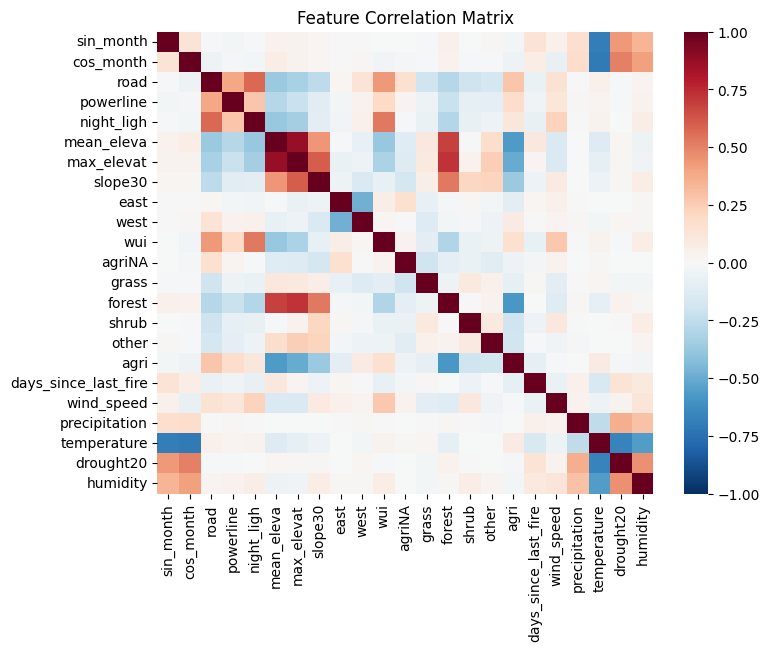

                 feature        VIF
6             max_elevat  40.250131
20           temperature  39.373369
5             mean_eleva  20.143295
18            wind_speed  13.227749
22              humidity  11.778162
13                forest   8.955485
2                   road   7.600444
9                   west   6.906954
16                  agri   6.019850
8                   east   4.690351
0              sin_month   3.606784
7                slope30   3.421069
1              cos_month   3.211186
21             drought20   3.140756
4             night_ligh   2.899453
10                   wui   2.615671
11                agriNA   2.465538
3              powerline   2.111818
14                 shrub   2.108210
12                 grass   1.502501
15                 other   1.473264
17  days_since_last_fire   1.401794
19         precipitation   1.286392


In [21]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define the set of columns to exclude
exclude = {
    "id", "start_time", "stop_time", "fire_occurred_x", "fire_occurred_y",
    "duration", "geometry", "spatial_block", "north", "south", "no_prior_fire"
}

# 2) Select only numeric columns from event_df, minus the excludes
numeric_cols = [
    c for c in event_df.select_dtypes(include=[np.number]).columns 
    if c not in exclude
]
X = event_df[numeric_cols].copy()

# 3) Correlation matrix
corr = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.title("Feature Correlation Matrix")
plt.show()

# 4) VIF computation
vif = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)
print(vif)


## Anderson gill cox model

In [ ]:
# cox model med ring buffer
from sksurv.metrics import brier_score
from sksurv.util import Surv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from lifelines import CoxPHFitter
from scipy.spatial import cKDTree

# ============================================
# 1) Initial Data Preprocessing
# ============================================
ensemble_models = []

# Centroids and basic features
event_df["centroid_x"] = event_df["geometry"].apply(lambda g: g.centroid.x)
event_df["centroid_y"] = event_df["geometry"].apply(lambda g: g.centroid.y)
event_df["duration"] = event_df["stop_time"] - event_df["start_time"]
event_df["log_days_since_last_fire"] = np.log1p(event_df["days_since_last_fire"])

# Spatial blocking for Train-Test Split
n_blocks_x, n_blocks_y = 4, 4
event_df["x_block"] = pd.cut(event_df["centroid_x"], bins=n_blocks_x, labels=False)
event_df["y_block"] = pd.cut(event_df["centroid_y"], bins=n_blocks_y, labels=False)
event_df["spatial_block"] = event_df["x_block"].astype(str) + "_" + event_df["y_block"].astype(str)

# Model Variables (note that we need to keep track of the features and scaling if we change anything when we want to plot after)
model_vars = ['id', 'start_time', 'stop_time', 'fire_occurred_x', 'sin_month',
       'cos_month', 'fire_occurred_y', 'road', 'powerline', 'night_ligh',
       'mean_eleva', 'max_elevat', 'slope30', 'north', 'east', 'south', 'west',
       'wui', 'agriNA', 'grass', 'forest', 'shrub', 'other', 'agri',
       'geometry', 'days_since_last_fire', 'wind_speed', 'precipitation',
       'temperature', 'drought20', 'humidity', 'no_prior_fire', 'duration', 
       'centroid_x', 'centroid_y']

df_model = event_df[model_vars].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = event_df["spatial_block"]

# ============================================
# 2) GroupKFold Spatial Cross-Validation
# ============================================
n_splits = 7
gkf = GroupKFold(n_splits=n_splits)
c_indices_train = []
c_indices_test = []
eval_times = np.arange(100, 2000, 200)
all_brier_scores = []
# ring‐buffer parameters 
# (logic in spatial blocking that we do not want to compute neighbors in testing straight from borders of spatial blocks)
R_inner  = 5000    # meters
R_outer  = 10000   # meters
lag_days = 10      # days
risk_dfs = [] 

for split, (train_idx, test_idx) in enumerate(
        gkf.split(df_model, groups=df_model["spatial_block"])
    ):
    print(f"\nProcessing spatial split {split+1}/{n_splits}")
    df_train = df_model.iloc[train_idx].drop(columns=["spatial_block"]).copy()
    df_test  = df_model.iloc[test_idx].drop(columns=["spatial_block"]).copy()

    coords_train = df_train[["centroid_x", "centroid_y"]].values
    coords_test  = df_test[["centroid_x", "centroid_y"]].values
    tree_train   = cKDTree(coords_train)

    # Ruggedness features
    # we do not use this
    for D in (df_train, df_test):
        D["ruggedness"] = D["max_elevat"] - D["mean_eleva"]
        D["elevation_ruggedness_index"] = D["ruggedness"] * D["mean_eleva"]

    # Initialize neighbor cols
    neighbor_features = [
        "neighbor_fire_risk", "neighbor_forest", "neighbor_road",
        "neighbor_powerline", "neighbor_ERI"
    ]
    # initialize neoghbor features as nans
    for D in (df_train, df_test):
        for f in neighbor_features:
            D[f] = np.nan

    # ————————————————————————————————————————————————————————————————
    # TRAIN: use neighbors within R_inner and stop_time < start_time - lag_days
    # ————————————————————————————————————————————————————————————————
    for i, point in enumerate(coords_train):
        idx = df_train.index[i]
        t0  = df_train.at[idx, "start_time"]
        if t0 == 0:
            df_train.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        # all pts within inner radius
        neigh_ids = tree_train.query_ball_point(point, r=R_inner)
        neigh_ids = [
            j for j in neigh_ids if j != i
            and df_train.iloc[j]["stop_time"] < (t0 - lag_days)
        ]
        if not neigh_ids:
            df_train.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        sub   = df_train.iloc[neigh_ids]
        dists = np.linalg.norm(coords_train[neigh_ids] - point, axis=1) + 1e-6
        w     = 1.0 / dists

        df_train.at[idx, "neighbor_fire_risk"]   = sub["fire_occurred_x"].sum() / sub["duration"].sum()
        df_train.at[idx, "neighbor_forest"]      = np.average(sub["forest"], weights=w)
        df_train.at[idx, "neighbor_road"]        = np.average(sub["road"],   weights=w)
        df_train.at[idx, "neighbor_powerline"]   = np.average(sub["powerline"], weights=w)
        df_train.at[idx, "neighbor_ERI"]         = np.average(sub["elevation_ruggedness_index"], weights=w)


    # ————————————————————————————————————————————————————————————————
    # TEST: use TRAIN history in annulus [R_inner, R_outer]
    # ————————————————————————————————————————————————————————————————
    for i, point in enumerate(coords_test):
        idx = df_test.index[i]
        t0  = df_test.at[idx, "start_time"]
        if t0 == 0:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        # all TRAIN pts within outer radius
        cand = tree_train.query_ball_point(point, r=R_outer)
        ring = []
        for j in cand:
            stop_j = df_train.iloc[j]["stop_time"]
            dist   = np.linalg.norm(point - coords_train[j])
            if stop_j < (t0 - lag_days) and R_inner <= dist <= R_outer:
                ring.append((j, dist))

        if not ring:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        idxs, dists = zip(*ring)
        sub   = df_train.iloc[list(idxs)]
        w     = 1.0 / (np.array(dists) + 1e-6)

        df_test.at[idx, "neighbor_fire_risk"]   = sub["fire_occurred_x"].sum() / sub["duration"].sum()
        df_test.at[idx, "neighbor_forest"]      = np.average(sub["forest"], weights=w)
        df_test.at[idx, "neighbor_road"]        = np.average(sub["road"],   weights=w)
        df_test.at[idx, "neighbor_powerline"]   = np.average(sub["powerline"], weights=w)
        df_test.at[idx, "neighbor_ERI"]         = np.average(sub["elevation_ruggedness_index"], weights=w)

    # Fill any remaining nan
    df_train["neighbor_fire_risk"] = df_train["neighbor_fire_risk"].fillna(0)
    df_test ["neighbor_fire_risk"] = df_test ["neighbor_fire_risk"].fillna(0)
    risk_dfs.append(pd.DataFrame({
        "split": split,
        "set":   "train",
        "neighbor_fire_risk": df_train["neighbor_fire_risk"].values
    }))

    risk_dfs.append(pd.DataFrame({
        "split": split,
        "set":   "test",
        "neighbor_fire_risk": df_test["neighbor_fire_risk"].values
    }))


    # ————————————————————————————————————————————————————————————————
    # Fill the other neighbor cols as before (using full R_inner radius)
    # ————————————————————————————————————————————————————————————————
    for i, point in enumerate(coords_train):
        idx = df_train.index[i]
        neigh = tree_train.query_ball_point(point, r=R_inner)
        neigh = [j for j in neigh if j != i]
        if neigh:
            sub   = df_train.iloc[neigh]
            w     = 1.0 / (np.linalg.norm(coords_train[neigh] - point, axis=1) + 1e-6)
            df_train.at[idx, "neighbor_forest"]      = np.average(sub["forest"], weights=w)
            df_train.at[idx, "neighbor_road"]        = np.average(sub["road"],   weights=w)
            df_train.at[idx, "neighbor_powerline"]   = np.average(sub["powerline"], weights=w)
            df_train.at[idx, "neighbor_ERI"]         = np.average(sub["elevation_ruggedness_index"], weights=w)
        else:
            df_train.loc[idx, neighbor_features] = df_train[neighbor_features].median()

    for i, point in enumerate(coords_test):
        idx = df_test.index[i]
        neigh = tree_train.query_ball_point(point, r=R_inner)
        if neigh:
            sub = df_train.iloc[neigh]
            w   = 1.0 / (np.linalg.norm(coords_train[neigh] - point, axis=1) + 1e-6)
            df_test.at[idx, "neighbor_forest"]      = np.average(sub["forest"], weights=w)
            df_test.at[idx, "neighbor_road"]        = np.average(sub["road"],   weights=w)
            df_test.at[idx, "neighbor_powerline"]   = np.average(sub["powerline"], weights=w)
            df_test.at[idx, "neighbor_ERI"]         = np.average(sub["elevation_ruggedness_index"], weights=w)
        else:
            df_test.loc[idx, neighbor_features] = df_train[neighbor_features].median()

    df_train[neighbor_features] = df_train[neighbor_features].fillna(df_train[neighbor_features].median())
    df_test [neighbor_features] = df_test [neighbor_features].fillna(df_train[neighbor_features].median())

    # ============================================
    # 3) Remaining Feature Engineering & Scaling
    # ============================================
    df_train["forest_diff"] = df_train["forest"] - df_train["neighbor_forest"]
    df_test ["forest_diff"] = df_test ["forest"] - df_test ["neighbor_forest"]

    for D in (df_train, df_test):
        D["forest_combined"] = (D["forest"] + D["neighbor_forest"]) / 2
        D["road_combined"]   = (D["road"]   + D["neighbor_road"])   / 2


    # we do actually not scale cos_month and sin_month which we might need to do
    # if we do that we have to revise our logic in the plotting functions
    cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "cos_month", "sin_month"
    ]
    scaler = MinMaxScaler()
    df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
    df_test [cols_to_scale] = scaler.transform(df_test [cols_to_scale])
    df_train["days_since_last_fire"] *= 0.1  
    df_test["days_since_last_fire"] *= 0.1

    for D in (df_train, df_test):
        D["temperature_sq"]         = D["temperature"] ** 2
        # D["wind_speed_sq"]          = D["wind_speed"] ** 2
        D["temp_forest_interaction"]= D["temperature"] * D["forest_combined"]
        D["dsf_x_no_prior"]         = D["days_since_last_fire"] * D["no_prior_fire"]

    # final features that we will use in the model
    final_features = [
    "fire_occurred_x", "id", "temperature", "drought20",
    "forest_combined", "grass", "shrub", "forest",
    "neighbor_fire_risk", "neighbor_powerline","road", "powerline",
    "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
    "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30", "night_ligh","other",
    "wui"
    ]

    df_train_final = df_train[final_features + ['duration']].copy()
    df_test_final  = df_test [final_features + ['duration']].copy()

    # ============================================
    # 4) Fit & Score Cox PH Model
    # ============================================
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(
        df_train_final,
        duration_col="duration",
        event_col="fire_occurred_x",
        cluster_col="id"
    )

    train_c_index = cph.score(df_train_final, scoring_method="concordance_index")
    test_c_index  = cph.score(df_test_final,  scoring_method="concordance_index")

    print(f"Split {split+1} Train C-index: {train_c_index:.4f}")
    print(f"Split {split+1} Test  C-index: {test_c_index:.4f}")

    c_indices_train.append(train_c_index)
    c_indices_test.append(test_c_index)
    # Survival data for Brier score
    y_train = Surv.from_arrays(
        event=df_train["fire_occurred_x"].astype(bool),
        time=df_train["duration"]
    )
    y_test = Surv.from_arrays(
        event=df_test["fire_occurred_x"].astype(bool),
        time=df_test["duration"]
    )
        # Predict survival functions
    surv_funcs = cph.predict_survival_function(df_test_final, times=eval_times)
    surv_array = surv_funcs.T.values
    all_risks = pd.concat(risk_dfs, ignore_index=True)

    # Compute Brier score curve
    _, bs_curve = brier_score(y_train, y_test, surv_array, eval_times)
    all_brier_scores.append(bs_curve.copy())  # store for aggregation

    ensemble_models.append({
        "model":        cph,
        "df_train":     df_train,        # with all those derived columns in it
        "scaler":       scaler,
        "coords_train": coords_train,
        "tree_train":   tree_train,
        "cols_to_scale": cols_to_scale,
        "final_features": final_features,
        "R_inner":      R_inner,
        "R_outer":      R_outer,
        "lag_days":     lag_days
    })


# Final aggregated results
print(f"\nAverage Train C-index: {np.mean(c_indices_train):.4f}")
print(f"Average Test  C-index:  {np.mean(c_indices_test):.4f}")



Processing spatial split 1/7
Split 1 Train C-index: 0.8148
Split 1 Test  C-index: 0.7704

Processing spatial split 2/7
Split 2 Train C-index: 0.8148
Split 2 Test  C-index: 0.7980

Processing spatial split 3/7
Split 3 Train C-index: 0.8184
Split 3 Test  C-index: 0.7793

Processing spatial split 4/7
Split 4 Train C-index: 0.8145
Split 4 Test  C-index: 0.8170

Processing spatial split 5/7
Split 5 Train C-index: 0.8134
Split 5 Test  C-index: 0.8292

Processing spatial split 6/7
Split 6 Train C-index: 0.8121
Split 6 Test  C-index: 0.8240

Processing spatial split 7/7
Split 7 Train C-index: 0.8157
Split 7 Test  C-index: 0.7941

Average Train C-index: 0.8148
Average Test  C-index:  0.8017


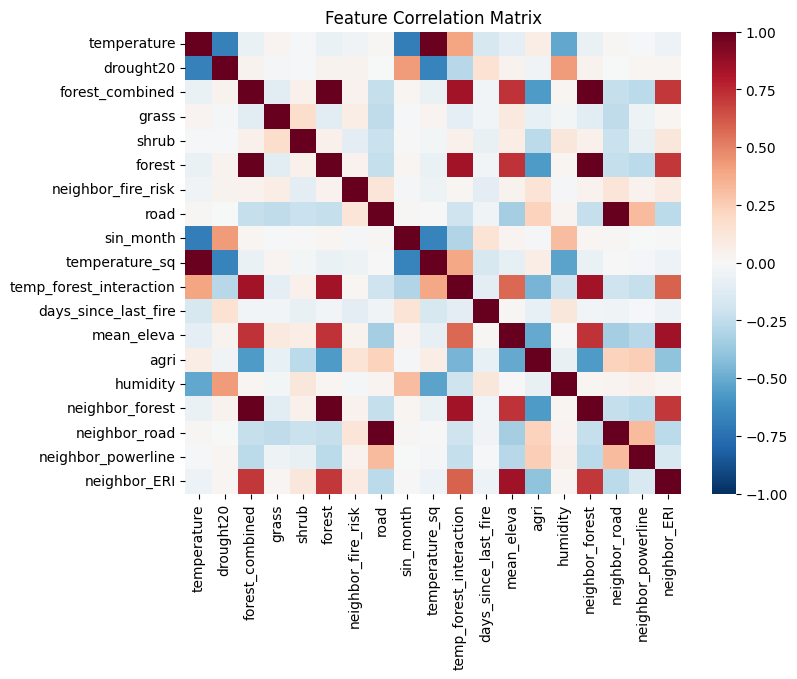

                    feature         VIF
2           forest_combined         inf
7                      road         inf
5                    forest         inf
15          neighbor_forest         inf
16            neighbor_road         inf
0               temperature  186.444929
9            temperature_sq  112.558649
10  temp_forest_interaction   24.322074
12               mean_eleva   15.637228
18             neighbor_ERI   10.764513
14                 humidity    6.725936
13                     agri    6.298944
1                 drought20    2.760541
6        neighbor_fire_risk    2.631809
8                 sin_month    2.482288
4                     shrub    2.117069
17       neighbor_powerline    2.091792
3                     grass    1.614218
11     days_since_last_fire    1.360805


c:\Users\hclt0\anaconda3\envs\bachpro\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

#
df = df_train_final.copy()

# 
for nb in ["neighbor_forest", "neighbor_road", "neighbor_powerline", "neighbor_ERI"]:
    df[nb] = df_train[nb]  

# only the numeric feature columns:
feature_cols = [c for c in df.columns if c not in ("fire_occurred_x","duration","id")]
X = df[feature_cols]

# Correlation heatmap
corr = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu_r", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# VIF table
vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
}).sort_values("VIF", ascending=False)

print(vif_df)


Overall zero rate: 0.16225382932166302
set        test     train
split                    
0      0.343974  0.086810
1      0.478884  0.073019
2      0.589912  0.072595
3      0.724102  0.074778
4      0.408050  0.071623
         count      mean       std  min       25%       50%       75%  \
set                                                                     
test   14624.0  0.003433  0.005918  0.0  0.000000  0.000000  0.004876   
train  58496.0  0.007250  0.007140  0.0  0.003034  0.005722  0.009177   

            max  
set              
test   0.062500  
train  0.083333  


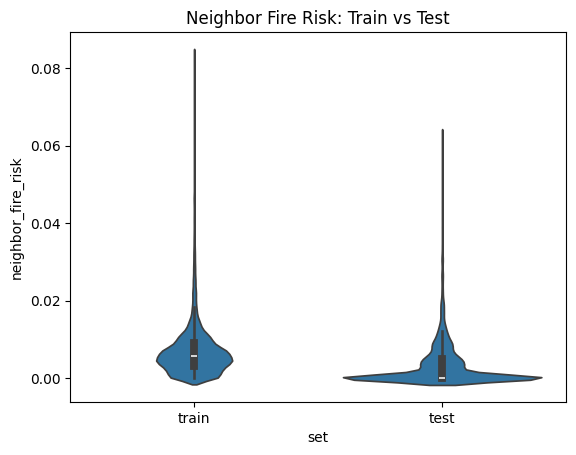

In [7]:
# after the for‐split loop
all_risks = pd.concat(risk_dfs, ignore_index=True)

# 1) overall zero‐rate
print("Overall zero rate:", (all_risks.neighbor_fire_risk == 0).mean())

# 2) zero‐rate per split and set
zero_by_split = (
    all_risks
    .assign(is_zero = lambda df: df.neighbor_fire_risk.eq(0))
    .groupby(["split","set"])["is_zero"]
    .mean()
    .unstack()
)
print(zero_by_split)

# 3) descriptive stats per set
print(
    all_risks
    .groupby("set")["neighbor_fire_risk"]
    .describe()
)

# 4) visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns  # optional

sns.violinplot(x="set", y="neighbor_fire_risk", data=all_risks)
plt.title("Neighbor Fire Risk: Train vs Test")
plt.show()


## Brier scores for AG model


Cox Ring Buffer IBS: 0.1363 ± 0.0372


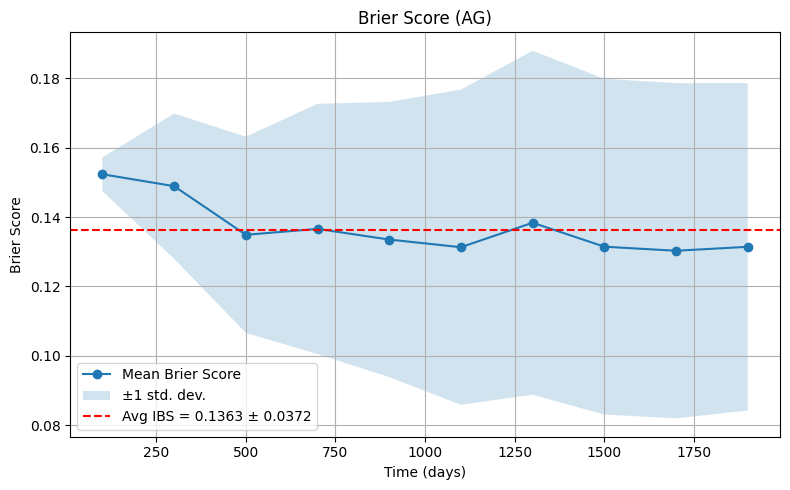

In [14]:
# Stack Brier scores from each fold
brier_matrix = np.stack(all_brier_scores)

# Calculate mean and std
mean_bs = brier_matrix.mean(axis=0)
std_bs = brier_matrix.std(axis=0, ddof=1)

# Integrated Brier Score per fold
ibs_per_fold = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix
]
ibs_mean = np.mean(ibs_per_fold)
ibs_std  = np.std(ibs_per_fold, ddof=1)

# Print IBS
print(f"\nCox Ring Buffer IBS: {ibs_mean:.4f} ± {ibs_std:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (AG)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Calibration for AG model

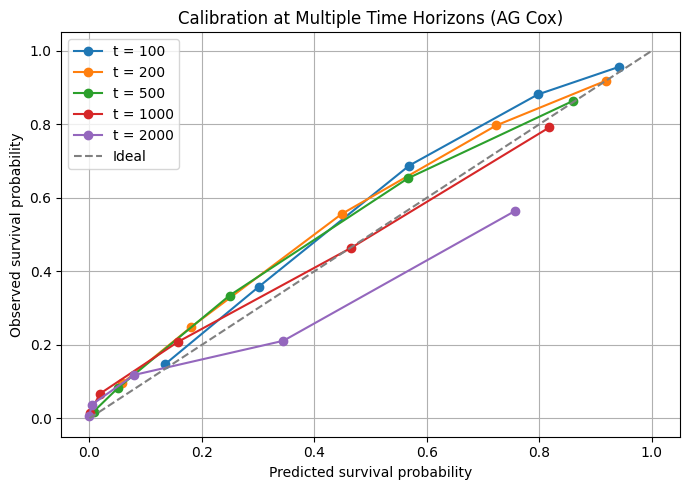

In [60]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

# 1. Choose time horizons
time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

calibration_data = []

for t in time_horizons:
    # 2. Predict survival probabilities at time t
    surv_df = cph.predict_survival_function(df_test[final_features], times=[t])
    
    # lifelines returns DataFrame with time as index and rows = individuals
    pred_surv = surv_df.T[t].values  # shape (n_samples,)
    
    # 3. Bin individuals into quantiles based on predicted survival
    df_test["pred_surv_prob"] = pred_surv
    df_test["risk_group"] = pd.qcut(pred_surv, q=n_bins, labels=False)

    group_pred, group_obs = [], []
    kmf = KaplanMeierFitter()

    for group in range(n_bins):
        sub = df_test[df_test["risk_group"] == group]
        if len(sub) < 1:
            continue
        group_pred.append(sub["pred_surv_prob"].mean())
        kmf.fit(durations=sub["duration"], event_observed=sub["fire_occurred_x"])
        group_obs.append(kmf.predict(t))

    for gp, go in zip(group_pred, group_obs):
        calibration_data.append({"time": t, "pred": gp, "obs": go})

# 4. Plot
df_cal = pd.DataFrame(calibration_data)

plt.figure(figsize=(7, 5))
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (AG Cox)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Computing brier scores for the AG model


Cox Ring Buffer IBS: 0.1355 ± 0.0382


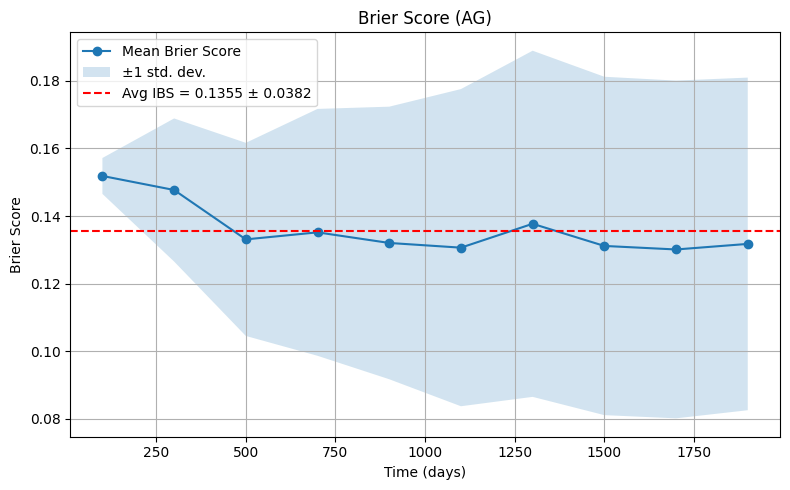

In [91]:
# Stack Brier scores from each fold
brier_matrix = np.stack(all_brier_scores)

# Calculate mean and std
mean_bs = brier_matrix.mean(axis=0)
std_bs = brier_matrix.std(axis=0, ddof=1)

# Integrated Brier Score per fold
ibs_per_fold = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix
]
ibs_mean = np.mean(ibs_per_fold)
ibs_std  = np.std(ibs_per_fold, ddof=1)

# Print IBS
print(f"\nCox Ring Buffer IBS: {ibs_mean:.4f} ± {ibs_std:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (AG)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


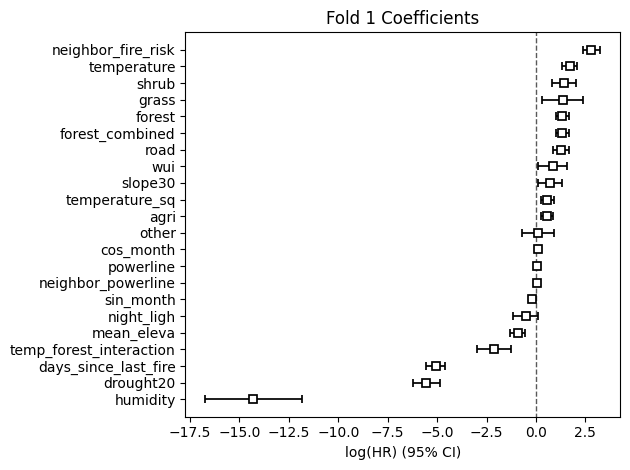

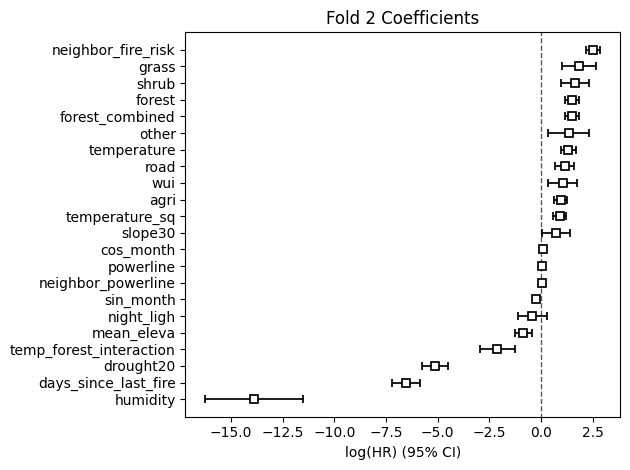

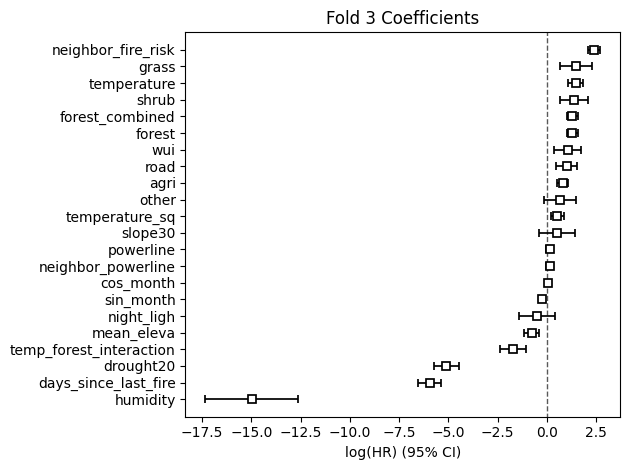

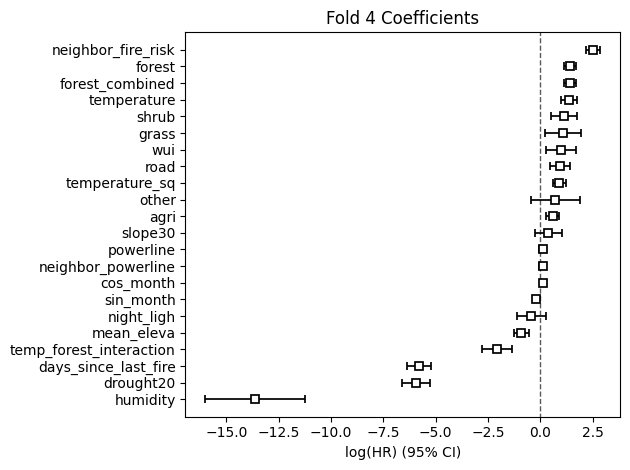

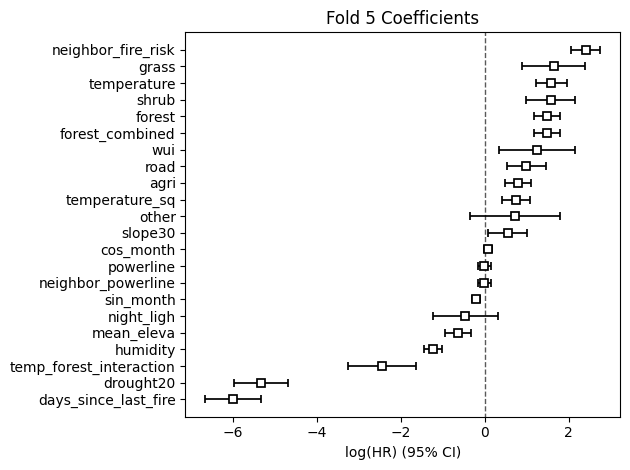

In [63]:
import matplotlib.pyplot as plt

for i, em in enumerate(ensemble_models):
    cph = em["model"]
    fig = cph.plot()
    plt.title(f"Fold {i+1} Coefficients")
    plt.tight_layout()
    plt.show()


## Helper functions for plotting logic

In [35]:

def compute_seasonality_cos_sin(t_days):
    """
    Compute monthly seasonality as cosine and sine, then min–max scale both into [0,1].
    
    Parameters
    ----------
    t_days : float or array-like
        Number of days since some origin; will be reduced mod 365.
    
    Returns
    -------
    cos_month_scaled : float or array-like
    sin_month_scaled : float or array-like
    """
    # Compute raw angle on [0, 2π)
    angle = 2 * np.pi * (np.asarray(t_days) % 365) / 365.0
    
    # Raw cos and sin in [-1,1]
    cos_raw = np.cos(angle)
    sin_raw = np.sin(angle)
    
    # Min–max scale from [-1,1] to [0,1]
    cos_scaled = (cos_raw + 1) / 2.0
    sin_scaled = (sin_raw + 1) / 2.0
    
    return cos_scaled, sin_scaled


def day_to_month(day):
    # Approximate conversion: assume 30-day months
    # so day 0 would mean jan 1st
    return min(12, int(day // 30) + 1)

def get_monthly_values(df_monthly, grid_id, month, stat='median'):
    """
    Retrieve monthly values (e.g., temperature, wind_speed, drought20)
    for the specified grid and month.
    Assumes df_monthly has columns like 'temperature_median', etc.
    """
    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    suffix = f"_{stat}"
    return {
        "temperature": row[f"temperature{suffix}"].values[0],
        # "wind_speed": row[f"wind_speed{suffix}"].values[0],
        "drought20": row[f"drought20{stat}"].values[0] if f"drought20{stat}" in row.columns else row[f"drought20{suffix}"].values[0],
        "humidity": row[f"humidity{suffix}"].values[0],
    }

def build_baseline_row(event_df, grid_id):
    """
    Build a baseline row for the given grid (using the median) and ensure that required
    fixed covariates are present by pulling the first non-null value if needed.
    """
    subset = event_df[event_df["id"] == grid_id]
    if subset.empty:
        raise ValueError(f"No data for grid_id={grid_id}")
    baseline = subset.median(numeric_only=True).to_dict()
    required_features = [
        "powerline", "grass", "shrub", "agri", "forest", "road",
        "slope30", "mean_eleva", "no_prior_fire", "centroid_x", "centroid_y"
    ]
    for var in required_features:
        if var not in baseline or pd.isna(baseline[var]):
            non_null_values = subset[var].dropna()
            baseline[var] = non_null_values.iloc[0] if not non_null_values.empty else 0.0
    return baseline

def compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius):
    """
    Compute neighbor-based features (fire risk, forest, road, powerline, ERI)
    using a cKDTree based on the row’s centroid.
    """
    point = np.array([row["centroid_x"], row["centroid_y"]])
    neighbors = tree_train.query_ball_point(point, neighbor_radius)
    if not neighbors:
        for col in ["neighbor_fire_risk", "neighbor_forest", "neighbor_road", 
                    "neighbor_powerline"]:
            row[col] = df_train[col].median()
        return row
    neighs = df_train.iloc[neighbors]
    weights = 1 / (np.linalg.norm(coords_train[neighbors] - point, axis=1) + 1e-6)
    row.update({
        "neighbor_fire_risk": neighs["fire_occurred_x"].sum() / (neighs["duration"].sum() + 1e-9),
        "neighbor_forest": np.average(neighs["forest"], weights=weights),
        "neighbor_road": np.average(neighs["road"], weights=weights),
        "neighbor_powerline": np.average(neighs["powerline"], weights=weights),
        # "neighbor_ERI": np.average(neighs["elevation_ruggedness_index"], weights=weights),
    })
    return row

## AG contour plot of evolving hazard, cumulative

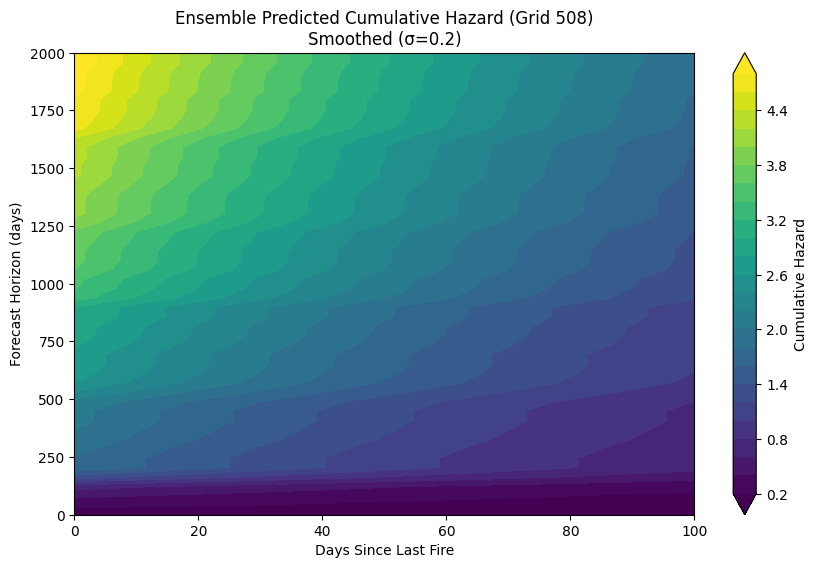

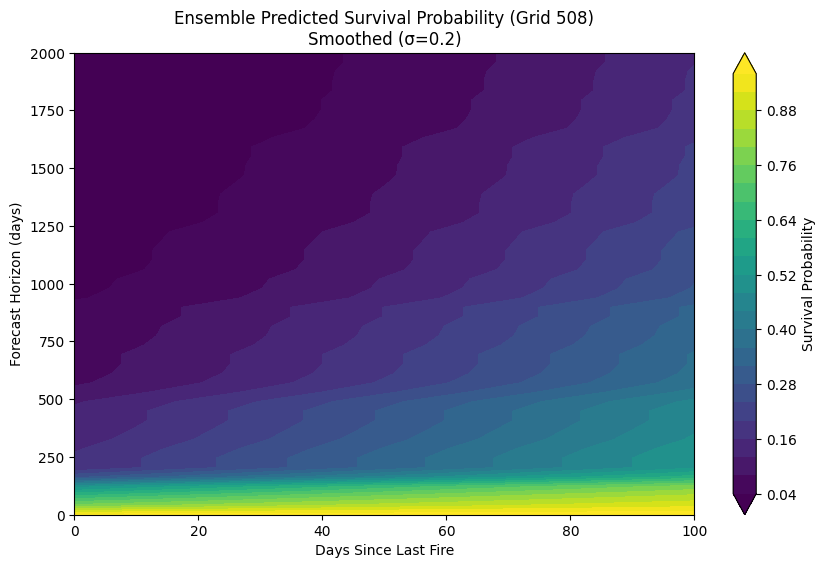

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # we'll use the 1D variant for horizontal smoothing
from scipy.ndimage import gaussian_filter   # only if you still want full 2D smoothing (not recommended)

def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=5000,
    sigma=1.0,
    delta_t=50
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d

    days_since_fire_range = np.arange(0, 101, 10)
    forecast_range = np.linspace(0, 2000, 50)

    #   Extract and interpolate the baseline cumulative hazard H_0(t)
    #
    # The Cox model learns a "baseline hazard" H_0(t), independent of covariates.
    # We extract it and interpolate it onto our forecast horizon grid.
    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]

    # grab the baseline cumulative‐hazard DataFrame, which is indexed by “duration” in training.
    raw_baseline_df = cox_model.baseline_cumulative_hazard_.reset_index()
    raw_baseline_df.columns = ["time", "H0"]

    # interpolate H0 onto exactly our forecast_range grid (50 points from 0 to 2000).
    H0_at_forecast = np.interp(
        forecast_range,
        raw_baseline_df["time"].values,
        raw_baseline_df["H0"].values,
        right=raw_baseline_df["H0"].values[-1]
    )
    # now H0_at_forecast[i] = H_0(t_i) for each t_i in forecast_range.
    # -----------------------------------------------------------

    # We'll compute hazard and survival probability for each (forecast_time, days_since_fire) pair.
    piecewise_hazard = np.zeros((len(forecast_range), len(days_since_fire_range)), dtype=float)
    survival_matrix = np.zeros_like(piecewise_hazard)

    # These are the model covariates (features) expected by the ensemble models.
    # make sure they match excactly the model
    predictor_vars = [
    "fire_occurred_x", "id", "temperature", "drought20",
    "forest_combined", "grass", "shrub", "forest",
    "neighbor_fire_risk", "neighbor_powerline","road", "powerline",
    "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
    "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30", "night_ligh","other",
    "wui"
    ]
    # Subset of variables that need scaling (standardization).
    cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "cos_month", "sin_month"
    ]

    # Outer loop → forecast time (how far ahead we are predicting)
    # Inner loop → days since last fire
    piecewise_hazard[0, :] = 0.0

    # Double‐loop over forecast_time (i) and days_since_fire (j).
    for i, forecast_time in enumerate(forecast_range):
        for j, dsf in enumerate(days_since_fire_range):
            
            cumulative_hazard = 0.0
            
            # Here is the key change → loop over t_step to evolve X(t)
            time_steps = np.arange(0, forecast_time + delta_t, delta_t)
            prev_H0_val = 0.0
            
            for t_step in time_steps:
                
                # recompute weather at this point in time
                month = day_to_month(t_step % 365)
                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)
                
                # build X(t_step)
                row = build_baseline_row(event_df, grid_id)
                row["days_since_last_fire"] = dsf
                cos_month, sin_month = compute_seasonality_cos_sin(t_step)
                row["cos_month"] = cos_month
                row["sin_month"] = sin_month
                row.update(monthly_vars)
                
                for var in [
                    "powerline", "grass", "shrub", "agri",
                    "slope30", "mean_eleva", "no_prior_fire", "forest", "road", "wui"
                ]:
                    if var not in row or pd.isna(row[var]):
                        row[var] = row.get(var, 0.0)
                
                row = compute_neighbor_features(
                    row,
                    model_obj['df_train'],
                    model_obj['coords_train'],
                    model_obj['tree_train'],
                    neighbor_radius
                )
                
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["road_combined"] = (row["road"] + row["neighbor_road"]) / 2
                row["temperature_sq"] = row["temperature"] ** 2
                row["wind_speed_sq"] = row["wind_speed"] ** 2
                row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]
                
                X_temp = pd.DataFrame([row])
                X_scaled = X_temp.copy()
                X_scaled[cols_to_scale] = model_obj['scaler'].transform(X_temp[cols_to_scale])
                
                X_scaled["temperature_sq"] = X_scaled["temperature"] ** 2
                X_scaled["wind_speed_sq"] = X_scaled["wind_speed"] ** 2
                X_scaled["temp_forest_interaction"] = (
                    X_scaled["temperature"] * X_scaled["forest_combined"]
                )
                
                X_final = X_scaled[predictor_vars].copy()
                
                # Predict log-partial hazard and get multiplier
                multiplier_preds = []
                for model_dict in ensemble_models:
                    lp_i = model_dict['model'].predict_log_partial_hazard(X_final).iloc[0]
                    multiplier_i = np.exp(lp_i)
                    multiplier_preds.append(multiplier_i)
                
                avg_multiplier = np.mean(multiplier_preds)
                
                # interpolate H₀(t_step) at this point in time
                H0_val = np.interp(
                    t_step,
                    raw_baseline_df["time"].values,
                    raw_baseline_df["H0"].values,
                    right=raw_baseline_df["H0"].values[-1]
                )
                
                # incremental delta_H0
                delta_H0 = H0_val - prev_H0_val
                prev_H0_val = H0_val
                
                # accumulate hazard
                cumulative_hazard += delta_H0 * avg_multiplier
            
            # store result at forecast_time, dsf
            piecewise_hazard[i, j] = cumulative_hazard
            survival_matrix[i, j] = np.exp(-cumulative_hazard)

    # Smooth across "days since fire" axis (axis=1) for cleaner plots.
    if sigma > 0:
        hazard_matrix_smoothed = gaussian_filter1d(piecewise_hazard, sigma=sigma, axis=1)
        survival_matrix_smoothed = gaussian_filter1d(survival_matrix, sigma=sigma, axis=1)
    else:
        hazard_matrix_smoothed = piecewise_hazard.copy()
        survival_matrix_smoothed = survival_matrix.copy()


    # X-axis: days since last fire
    # Y-axis: forecast horizon
    X_plot, Y_plot = np.meshgrid(days_since_fire_range, forecast_range)

    # Plot the piecewise cumulative hazard
    plt.figure(figsize=(10, 6))
    cp1 = plt.contourf(
        X_plot,
        Y_plot,
        hazard_matrix_smoothed,
        levels=30,
        extend="both"
    )
    plt.colorbar(cp1, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Ensemble Predicted Cumulative Hazard (Grid {grid_id})\nSmoothed (σ={sigma})")
    plt.xlim(days_since_fire_range[0], days_since_fire_range[-1])
    plt.show()

    # Plot the piecewise survival probability = exp(–hazard)
    plt.figure(figsize=(10, 6))
    cp2 = plt.contourf(
        X_plot,
        Y_plot,
        survival_matrix_smoothed,
        levels=30,
        extend="both"
    )
    plt.colorbar(cp2, label="Survival Probability")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Ensemble Predicted Survival Probability (Grid {grid_id})\nSmoothed (σ={sigma})")
    plt.xlim(days_since_fire_range[0], days_since_fire_range[-1])
    plt.show()


# Usage remains exactly the same:
predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=508,                    # Change to desired grid ID
    statistic='median',             # Or 'q75', etc.
    neighbor_radius=5000,
    sigma=0.2                       # Horizontal smoothing (days‐since‐fire) only
)


## this below is formely used and needs revision since feature inputs are different

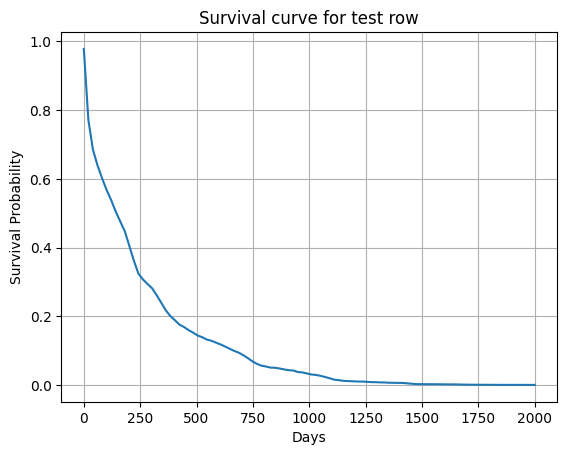

In [69]:
# Predict survival curve at 100 time points
model_dict = ensemble_models[0]

# Recreate a test input row
row = build_baseline_row(event_df, grid_id=508)
row["days_since_last_fire"] = 60
row["cos_month"], row["sin_month"] = compute_seasonality_cos_sin(0)

# Add monthly vars (month 1 arbitrarily)
monthly_vars = get_monthly_values(df_monthly, grid_id=508, month=1, stat="median")
row.update(monthly_vars)

# Fill any required columns
for var in ["powerline", "grass", "shrub", "agri", "slope30", "mean_eleva", "no_prior_fire"]:
    if var not in row or pd.isna(row[var]):
        row[var] = row.get(var, 0.0)

# Add neighbors
row = compute_neighbor_features(row, model_dict['df_train'],
                                model_dict['coords_train'],
                                model_dict['tree_train'], neighbor_radius=5000)
row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
row["road_combined"] = (row["road"] + row["neighbor_road"]) / 2
row["start_time"] = 0.0  # Important if model was trained with entry_col

# Convert to DataFrame and scale
X_temp = pd.DataFrame([row])
X_scaled = X_temp.copy()
X_scaled[model_dict["cols_to_scale"]] = model_dict["scaler"].transform(X_temp[model_dict["cols_to_scale"]])

X_scaled["temperature_sq"] = X_scaled["temperature"] ** 2
X_scaled["wind_speed_sq"] = X_scaled["wind_speed"] ** 2
X_scaled["temp_forest_interaction"] = X_scaled["temperature"] * X_scaled["forest_combined"]

# Select predictors
predictor_vars = [
    "fire_occurred_x", "id",
    "temperature", "wind_speed", "drought20",
    "forest_combined", "grass", "shrub",
    "no_prior_fire", "neighbor_fire_risk",
    "neighbor_powerline",
    "cos_month", "sin_month",
    "temperature_sq", "wind_speed_sq",
    "temp_forest_interaction",
    "days_since_last_fire",
    "mean_eleva", "agri", "humidity", "wui"
]
X_final = X_scaled[predictor_vars].copy()

times = np.linspace(0, 2000, 100)
sf = model_dict['model'].predict_survival_function(X_final, times=times)

# Now sf is a DataFrame with shape (1, 100), columns = time points
# So use .values.flatten() to get the curve as 1D
plt.plot(times, sf.values.flatten())
plt.title("Survival curve for test row")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


## random forest survival model



In [ ]:
# med korrekte nbr fire risk med ring area buffer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from scipy.spatial import cKDTree
from sksurv.metrics import brier_score

# ============================================
# 1) Initial Data Preprocessing
# ============================================
event_df["centroid_x"] = event_df["geometry"].apply(lambda g: g.centroid.x)
event_df["centroid_y"] = event_df["geometry"].apply(lambda g: g.centroid.y)
event_df["duration"] = event_df["stop_time"] - event_df["start_time"]
event_df["log_days_since_last_fire"] = np.log1p(event_df["days_since_last_fire"])

# Spatial blocking
n_blocks_x, n_blocks_y = 4, 4
event_df["x_block"] = pd.cut(event_df["centroid_x"], bins=n_blocks_x, labels=False)
event_df["y_block"] = pd.cut(event_df["centroid_y"], bins=n_blocks_y, labels=False)
event_df["spatial_block"] = event_df["x_block"].astype(str) + "_" + event_df["y_block"].astype(str)

# Variables for modeling (include start_time/stop_time for time‐filtering)
model_vars = [
    "fire_occurred_x", 
    "start_time", "stop_time", "duration",
    "temperature", "drought20",
    "forest", "road", "grass", "shrub", "agri",
    "days_since_last_fire", "powerline",
    "cos_month", "sin_month", "slope30",
    "max_elevat", "mean_eleva", "no_prior_fire",
    "centroid_x", "centroid_y", "humidity", "wui"
]

df_model = event_df[model_vars].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = event_df["spatial_block"]

# ============================================
# 2) GroupKFold Spatial Cross-Validation
# ============================================
n_splits = 7
gkf = GroupKFold(n_splits=n_splits)
R_outer = 10000
R_inner = 5000
lag_days = 10
# Initialize lists to store performance metrics and models
c_indices_train = []
c_indices_test  = []
ensemble_rsf_models = []
eval_times = np.arange(100, 2000, 200)
all_brier_scores_rsf = []


for split, (train_idx, test_idx) in enumerate(
        gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\n--- Split {split+1}/{n_splits} ---")

    # Split data into train and test sets (dropping spatial_block column)
    df_train = df_model.iloc[train_idx].drop(columns=["spatial_block"]).copy()
    df_test  = df_model.iloc[test_idx] .drop(columns=["spatial_block"]).copy()

    # Build KD-tree for fast neighbor lookup (train centroids)
    coords_train = df_train[["centroid_x", "centroid_y"]].values
    coords_test  = df_test[["centroid_x", "centroid_y"]].values
    tree_train   = cKDTree(coords_train)
    neighbor_radius = 5000

    # ruggedness
    for df in (df_train, df_test):
        df["ruggedness"] = df["max_elevat"] - df["mean_eleva"]
        df["elevation_ruggedness_index"] = df["ruggedness"] * df["mean_eleva"]

    # Initialize neighbor feature columns (will be filled later)
    neighbor_features = [
        "neighbor_fire_risk", "neighbor_forest",
        "neighbor_road",      "neighbor_powerline"
    ]
    for df in (df_train, df_test):
        for f in neighbor_features:
            df[f] = np.nan

    # ---- Train set: compute neighbor features ----

    # For each training point:
    # - Compute neighbor fire risk (time-filtered, within radius)
    # - Compute neighbor averages for forest, road, powerline (static averages, no time filter)
    for i, point in enumerate(coords_train):
        idx = df_train.index[i]
        t0  = df_train.at[idx, "start_time"]

        # Neighbor fire risk: risk = 0 if start_time <= 0
        if t0 <= 0:
            df_train.at[idx, "neighbor_fire_risk"] = 0.0
        else:
            # Find neighbors within radius (excluding self), filter by stop_time < t0
            neigh_ids = tree_train.query_ball_point(point, neighbor_radius)
            neigh_ids = [n for n in neigh_ids if n != i]
            if not neigh_ids:
                df_train.at[idx, "neighbor_fire_risk"] = 0.0
            else:
                past = df_train.iloc[neigh_ids]
                past = past[past["stop_time"] < t0]
                if past.empty:
                    df_train.at[idx, "neighbor_fire_risk"] = 0.0
                else:
                    df_train.at[idx, "neighbor_fire_risk"] = (
                        past["fire_occurred_x"].sum() / past["duration"].sum()
                    )

        # Static neighbor averages (no time filter)
        neigh_ids = tree_train.query_ball_point(point, neighbor_radius)
        neigh_ids = [n for n in neigh_ids if n != i]
        if neigh_ids:
            weights = 1 / (
                np.linalg.norm(point - coords_train[neigh_ids], axis=1) + 1e-6
            )
            neighs = df_train.iloc[neigh_ids]
            df_train.loc[idx, "neighbor_forest"]    = np.average(neighs["forest"],       weights=weights)
            df_train.loc[idx, "neighbor_road"]      = np.average(neighs["road"],         weights=weights)
            df_train.loc[idx, "neighbor_powerline"] = np.average(neighs["powerline"],    weights=weights)
        else:
            # Fallback: use median if no neighbors
            df_train.loc[idx, neighbor_features] = df_train[neighbor_features].median()

    # ---- Test set: compute neighbor features ----

    # Use neighbors from train set only (avoids leakage!)
    # Apply ring-based spatial + temporal filter for neighbor fire risk and averages
    for i, point in enumerate(coords_test):
        idx = df_test.index[i]
        t0  = df_test.at[idx, "start_time"]

        if t0 <= 0:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        # Step 1: Find all neighbors in outer radius
        candidates = tree_train.query_ball_point(point, r=R_outer)

        # Step 2: Filter by temporal lag and ring zone
        ring_neighbors = []
        for j in candidates:
            stop_j = df_train.iloc[j]["stop_time"]
            if stop_j < (t0 - lag_days):
                dist = np.linalg.norm(point - coords_train[j])
                if R_inner <= dist <= R_outer:
                    ring_neighbors.append((j, dist))

        if not ring_neighbors:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue
        # Compute weighted averages for neighbors in ring
        idxs, dists = zip(*ring_neighbors)
        w = 1.0 / (np.array(dists) + 1e-6)
        sub = df_train.iloc[list(idxs)]

        # Fire risk
        df_test.at[idx, "neighbor_fire_risk"] = sub["fire_occurred_x"].sum() / sub["duration"].sum()

        # Weighted averages
        df_test.at[idx, "neighbor_forest"]    = np.average(sub["forest"], weights=w)
        df_test.at[idx, "neighbor_road"]      = np.average(sub["road"], weights=w)
        df_test.at[idx, "neighbor_powerline"] = np.average(sub["powerline"], weights=w)

    # fill any remaining NaNs
    df_train[neighbor_features] = df_train[neighbor_features].fillna(df_train[neighbor_features].median())
    df_test [neighbor_features] = df_test [neighbor_features].fillna(df_train[neighbor_features].median())

    # combine forest & road
    for df in (df_train, df_test):
        df["forest_combined"] = (df["forest"] + df["neighbor_forest"]) / 2
        df["road_combined"]   = (df["road"]   + df["neighbor_road"])   / 2

    # ============================================
    # 3) Remaining Feature Engineering & Scaling
    # ============================================
    cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", 
    "forest",  "powerline", "wui", "road_combined", "cos_month", "sin_month"
    ]
    scaler = MinMaxScaler()
    df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
    df_test [cols_to_scale] = scaler.transform(df_test [cols_to_scale])

    for df in (df_train, df_test):
        df["temperature_sq"]         = df["temperature"] ** 2
        df["temp_forest_interaction"] = df["temperature"] * df["forest_combined"]
        df["dsf_x_no_prior"]          = df["days_since_last_fire"] * df["no_prior_fire"]

    # ============================================
    # 4) Fit & Score RandomSurvivalForest
    # ============================================
    rsf_features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "agri",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
        "cos_month", "temperature_sq", "temp_forest_interaction",
        "mean_eleva", "road_combined", "powerline", "sin_month", "humidity", "wui"
    ]
    # Convert fire_occurred_x to boolean for sksurv
    df_train["fire_occurred_x"] = df_train["fire_occurred_x"].astype(bool)
    df_test ["fire_occurred_x"] = df_test ["fire_occurred_x"].astype(bool)

    # Prepare survival labels (event, duration)
    y_train = Surv.from_dataframe("fire_occurred_x", "duration", df_train)
    y_test  = Surv.from_dataframe("fire_occurred_x", "duration", df_test)
    X_train = df_train[rsf_features]
    X_test  = df_test [rsf_features]

    # Apply sample weights (downweight intervals with days_since_last_fire == 1)
    # this didn't get used though so you can look away from that, and rsf don't work that way aswell
    w = np.ones(len(df_train))
    w[df_train["days_since_last_fire"] == 1] *= 0.4
    
    # Train Random Survival Forest model
    rsf = RandomSurvivalForest(
        n_estimators=200,
        min_samples_split=30,
        min_samples_leaf=40,
        max_features=0.15,
        n_jobs=2,
        random_state=12
    )
    rsf.fit(X_train, y_train, sample_weight=w)

    # Predict risk scores
    train_pred = rsf.predict(X_train)
    test_pred  = rsf.predict(X_test)

    # Compute Concordance Index (C-index) for train/test
    c_train = concordance_index_censored(
        y_train["fire_occurred_x"], y_train["duration"], train_pred
    )[0]
    c_test  = concordance_index_censored(
        y_test ["fire_occurred_x"], y_test ["duration"], test_pred
    )[0]
    # Predict survival functions on test set
    surv_funcs = rsf.predict_survival_function(X_test, return_array=False)

    # Convert to 2D array: (n_samples, n_eval_times)
    sf_array = np.asarray([
        fn(eval_times) for fn in surv_funcs
    ])

    # Compute Brier score curve
    _, bs_curve = brier_score(y_train, y_test, sf_array, eval_times)

    # Store the curve
    all_brier_scores_rsf.append(bs_curve.copy())

    print(f"Split {split+1} Train C-index: {c_train:.4f}")
    print(f"Split {split+1} Test  C-index: {c_test:.4f}")

    ensemble_rsf_models.append({
        "model": rsf,
        "X_test": X_test,
        "y_test":  y_test
    })
    c_indices_train.append(c_train)
    c_indices_test .append(c_test)

# Final summary
print(f"\nAverage Train C-index: {np.mean(c_indices_train):.4f}")
print(f"Average Test  C-index:  {np.mean(c_indices_test):.4f}")



--- Split 1/7 ---
Split 1 Train C-index: 0.8518
Split 1 Test  C-index: 0.7711

--- Split 2/7 ---
Split 2 Train C-index: 0.8510
Split 2 Test  C-index: 0.8174

--- Split 3/7 ---
Split 3 Train C-index: 0.8531
Split 3 Test  C-index: 0.8035

--- Split 4/7 ---
Split 4 Train C-index: 0.8515
Split 4 Test  C-index: 0.8318

--- Split 5/7 ---
Split 5 Train C-index: 0.8477
Split 5 Test  C-index: 0.8433

--- Split 6/7 ---
Split 6 Train C-index: 0.8478
Split 6 Test  C-index: 0.8545

--- Split 7/7 ---
Split 7 Train C-index: 0.8563
Split 7 Test  C-index: 0.8136

Average Train C-index: 0.8513
Average Test  C-index:  0.8193


## Brier scores for RSF


RSF Integrated Brier Score (IBS): 0.1197 ± 0.0361


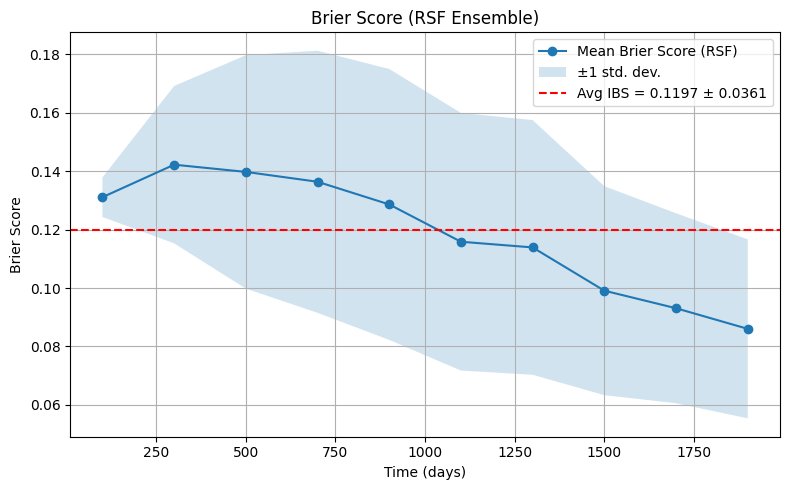

In [14]:
# Final Brier score aggregation
brier_matrix_rsf = np.stack(all_brier_scores_rsf)
mean_bs_rsf = brier_matrix_rsf.mean(axis=0)
std_bs_rsf = brier_matrix_rsf.std(axis=0, ddof=1)

# Integrated Brier Score (IBS)
ibs_per_fold_rsf = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix_rsf
]
ibs_mean_rsf = np.mean(ibs_per_fold_rsf)
ibs_std_rsf = np.std(ibs_per_fold_rsf, ddof=1)

print(f"\nRSF Integrated Brier Score (IBS): {ibs_mean_rsf:.4f} ± {ibs_std_rsf:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs_rsf, marker="o", label="Mean Brier Score (RSF)")
plt.fill_between(eval_times,
                 mean_bs_rsf - std_bs_rsf,
                 mean_bs_rsf + std_bs_rsf,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean_rsf, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean_rsf:.4f} ± {ibs_std_rsf:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (RSF Ensemble)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Calibration plotting

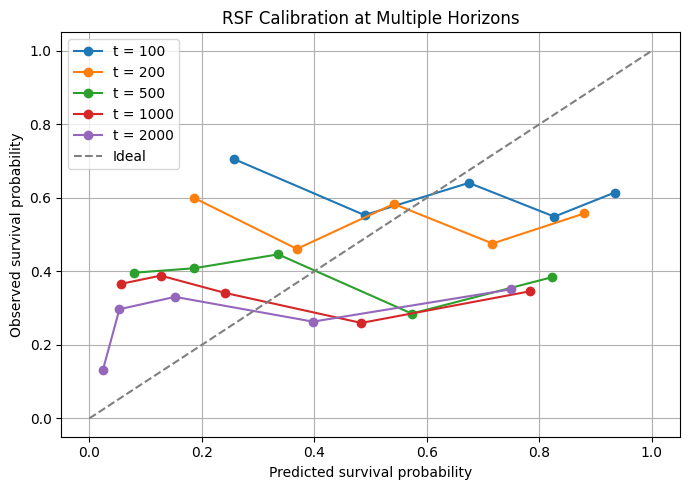

In [15]:
from lifelines import KaplanMeierFitter

time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5
calibration_data = []

sf_df = rsf.predict_survival_function(X_test, return_array=False)
sf_df = pd.DataFrame(
    data=np.array([
        [fn(t) if t <= fn.x[-1] else fn.y[-1] for t in time_horizons]
        for fn in sf_df
    ]),
    columns=time_horizons
)


for t in time_horizons:
    df_test["pred_surv_prob"] = sf_df[t]
    df_test["risk_group"] = pd.qcut(df_test["pred_surv_prob"], q=n_bins, labels=False)
    
    group_pred, group_obs = [], []
    kmf = KaplanMeierFitter()
    
    for g in range(n_bins):
        sub = df_test[df_test["risk_group"] == g]
        if len(sub) == 0:
            continue
        group_pred.append(sub["pred_surv_prob"].mean())
        kmf.fit(sub["duration"], sub["fire_occurred_x"])
        group_obs.append(kmf.predict(t))
    
    for gp, go in zip(group_pred, group_obs):
        calibration_data.append({"time": t, "pred": gp, "obs": go})

df_cal = pd.DataFrame(calibration_data)
plt.figure(figsize=(7, 5))
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("RSF Calibration at Multiple Horizons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## permutation importance, remember to check for correct features

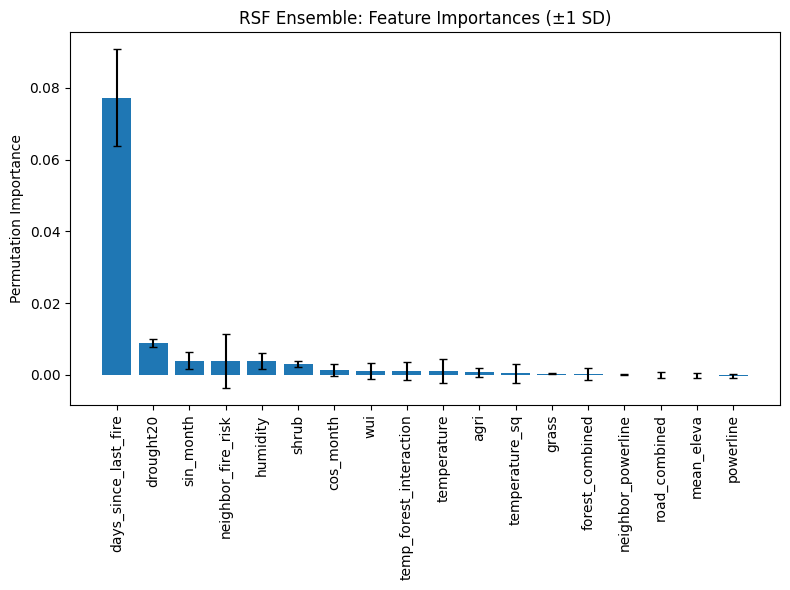

In [17]:
# new feature importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# 1) RSF scorer returning C‐index
def rsf_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return concordance_index_censored(
        y["fire_occurred_x"], y["duration"], preds
    )[0]

# 2) Feature list in the same order you trained on
rsf_features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "agri",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
        "cos_month", "temperature_sq", "temp_forest_interaction",
        "mean_eleva", "road_combined", "powerline", "sin_month", "humidity", "wui"
    ]

# 3) Compute permutation importances for each fold
all_importances = []
for fold in ensemble_rsf_models:
    model  = fold["model"]
    X_test = fold["X_test"]
    y_test = fold["y_test"]

    # sample by integer positions to align X and y
    n_sub = min(len(X_test), 1000)
    rng   = np.random.RandomState(0)
    idxs  = rng.choice(len(X_test), size=n_sub, replace=False)
    X_sub = X_test.iloc[idxs]
    y_sub = y_test[idxs]

    r = permutation_importance(
        model,
        X_sub, y_sub,
        scoring=rsf_scorer,
        n_repeats=2,
        random_state=42,
        n_jobs=1
    )
    all_importances.append(r.importances_mean)

# 4) Aggregate across folds
imp_mat  = np.vstack(all_importances)
mean_imp = imp_mat.mean(axis=0)
std_imp  = imp_mat.std(axis=0)

feat_imp = (
    pd.DataFrame({
        "feature":         rsf_features,
        "mean_importance": mean_imp,
        "std_importance":  std_imp
    })
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

# 5) Plot
plt.figure(figsize=(8,6))
plt.bar(
    feat_imp["feature"],
    feat_imp["mean_importance"],
    yerr=feat_imp["std_importance"],
    capsize=3
)
plt.xticks(rotation=90)
plt.ylabel("Permutation Importance")
plt.title("RSF Ensemble: Feature Importances (±1 SD)")
plt.tight_layout()
plt.show()


## RSF Plot

Since the RSF survival function is not guaranteed to be monotonically decreasing (unlike in a Cox model),  
we manually enforce that the survival probability cannot increase over time.

We do this by adding:

```python
surv_prob = min(surv_prob, prev_surv_prob)


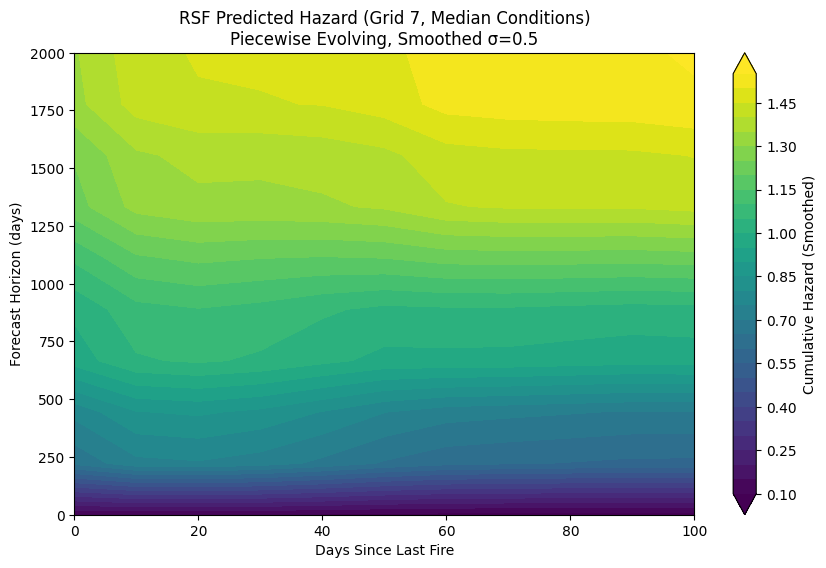

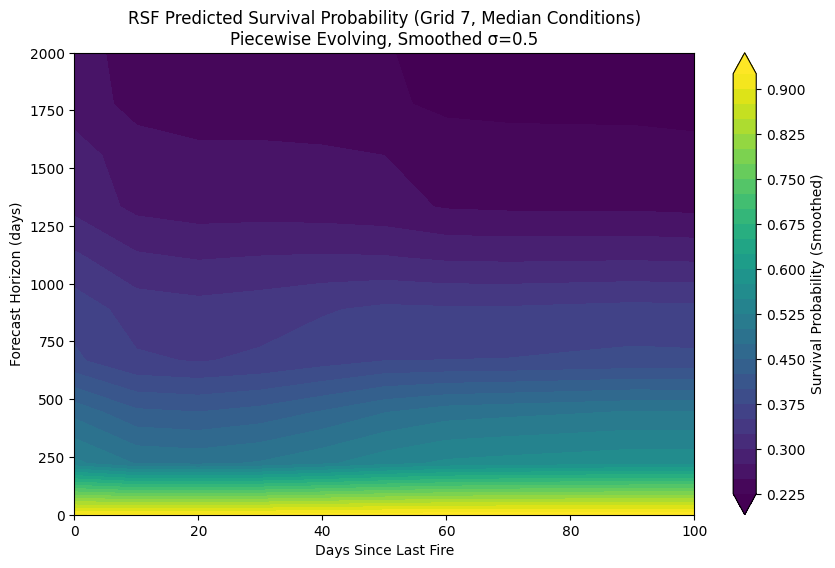

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# --- Prediction and Plotting Function ---

def predict_and_plot_with_survival(rsf, df_train, coords_train, tree_train, scaler, event_df, df_monthly,
                                            grid_id, statistic='median', neighbor_radius=5000, sigma=0.5, delta_t=10):
    """
    Predict and plot both cumulative hazard and survival probability over a grid of 
    "days since last fire" (x-axis) vs. forecast horizon (y-axis) for the given grid_id.
    Now using piecewise accumulation of hazard over time (covariates evolve through time).
    """
    rsf_features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "agri",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
        "cos_month", "temperature_sq", "temp_forest_interaction",
        "mean_eleva", "road_combined", "powerline", "sin_month", "humidity", "wui"
    ]
    cols_to_scale_full = [
        "temperature", "drought20", "forest_combined",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
        "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", 
        "forest", "powerline", "wui", "road_combined", "cos_month", "sin_month"
    ]
    derived_features = [
        "temperature_sq", "temp_forest_interaction",
        "cos_month", "no_prior_fire", "sin_month"
    ]
    
    # Define ranges
    days_since_fire_range = np.arange(0, 101, 10)
    forecast_range = np.linspace(0, 2000, 10)
    
    hazard_matrix = np.zeros((len(forecast_range), len(days_since_fire_range)))
    survival_matrix = np.zeros((len(forecast_range), len(days_since_fire_range)))
    
    baseline = build_baseline_row(event_df, grid_id)
    
    for i, forecast_time in enumerate(forecast_range):
        for j, dsf in enumerate(days_since_fire_range):
            
            cumulative_hazard = 0.0
            survival = 1.0
            
            # Step through time 0 → forecast_time in delta_t increments
            time_steps = np.arange(0, forecast_time + delta_t, delta_t)
            prev_surv_prob = 1.0
            
            for t_step in time_steps:
                month = day_to_month(t_step % 365)
                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)
                
                row = baseline.copy()
                row["days_since_last_fire"] = dsf
                cos_month, sin_month = compute_seasonality_cos_sin(t_step)
                row["cos_month"] = cos_month
                row["sin_month"] = sin_month
                row.update(monthly_vars)
                
                required_fixed = ["powerline", "grass", "shrub", "agri", "mean_eleva", "no_prior_fire"]
                for var in required_fixed:
                    if var not in row:
                        row[var] = baseline.get(var, 0.0)
                
                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
                
                # Feature engineering
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["road_combined"] = (row["road"] + row["neighbor_road"]) / 2
                row["temperature_sq"] = row["temperature"] ** 2
                row["wind_speed_sq"] = row["wind_speed"] ** 2
                row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]
                row["dsf_x_no_prior"] = row["days_since_last_fire"] * row["no_prior_fire"]
                
                X_temp = pd.DataFrame([row])
                X_scaled_full = pd.DataFrame(scaler.transform(X_temp[cols_to_scale_full]), 
                                             columns=cols_to_scale_full)
                X_final = pd.concat([X_scaled_full, X_temp[derived_features].reset_index(drop=True)], axis=1)
                X_final = X_final[rsf_features]
                
                # Predict survival function at this time step
                surv_probs = []
                for model in ensemble_rsf_models:
                    surv_func = model["model"].predict_survival_function(X_final)[0]
                    surv_probs.append(surv_func(t_step))
                
                surv_prob = np.mean(surv_probs)
                surv_prob = min(surv_prob, prev_surv_prob)
                
                
                if surv_prob <= 0 or np.isnan(surv_prob):
                    print(f"Problematic surv_prob: t_step={t_step}, dsf={dsf}, surv_prob={surv_prob}")
                    continue  # skip this t_step to avoid NaNs
                
                # Compute incremental hazard for this time step
                # ΔH = -log(S(t)) + log(S(t-1))
                delta_H = -np.log(surv_prob + 1e-10) + np.log(prev_surv_prob + 1e-10)
                
                # Accumulate hazard
                cumulative_hazard += delta_H
                survival = np.exp(-cumulative_hazard)
                
                # Update previous survival
                prev_surv_prob = surv_prob
            
            # Store in matrix at forecast_time = i, dsf = j
            hazard_matrix[i, j] = cumulative_hazard
            survival_matrix[i, j] = survival
    
    # Smooth
    hazard_matrix_smoothed = gaussian_filter(hazard_matrix, sigma=sigma)
    survival_matrix_smoothed = gaussian_filter(survival_matrix, sigma=sigma)
    
    # Meshgrid
    X_plot, Y_plot = np.meshgrid(days_since_fire_range, forecast_range)
    
    # Plot cumulative hazard
    plt.figure(figsize=(10, 6))
    plt.contourf(X_plot, Y_plot, hazard_matrix_smoothed, levels=30, extend="both")
    plt.colorbar(label="Cumulative Hazard (Smoothed)")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"RSF Predicted Hazard (Grid {grid_id}, {statistic.capitalize()} Conditions)\nPiecewise Evolving, Smoothed σ={sigma}")
    plt.xlim(days_since_fire_range[0], days_since_fire_range[-1])
    plt.show()
    
    # Plot survival probability
    plt.figure(figsize=(10, 6))
    plt.contourf(X_plot, Y_plot, survival_matrix_smoothed, levels=30, extend="both")
    plt.colorbar(label="Survival Probability (Smoothed)")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"RSF Predicted Survival Probability (Grid {grid_id}, {statistic.capitalize()} Conditions)\nPiecewise Evolving, Smoothed σ={sigma}")
    plt.xlim(days_since_fire_range[0], days_since_fire_range[-1])
    plt.show()


# Example usage for grid 7 with median conditions:
predict_and_plot_with_survival(rsf, df_train, coords_train, tree_train, scaler, event_df, df_monthly,
                               grid_id=7, statistic='median', neighbor_radius=5000)




In [12]:
grid_508_count = event_df[event_df["id"] == 508].shape[0]
print("Number of instances of grid 508:", grid_508_count)

Number of instances of grid 508: 177


## Deep.surv

In [ ]:
# deepsurv model med GKF i stedet for og hensyn til nbr fire risk
# Import necessary libraries for the pipeline
# denne er med ringe buffer
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
import numpy as np
import torch
from torch.optim import Adam
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn.cluster import KMeans
from sksurv.util import Surv

seed = 42
np.random.seed(seed)
# Assume df_model is a DataFrame containing all features and a 'spatial_block' column for grouping
event_df["centroid_x"] = event_df["geometry"].apply(lambda g: g.centroid.x)
event_df["centroid_y"] = event_df["geometry"].apply(lambda g: g.centroid.y)
event_df["duration"] = event_df["stop_time"] - event_df["start_time"]
event_df["log_days_since_last_fire"] = np.log1p(event_df["days_since_last_fire"])

# Spatial blocking
n_blocks_x, n_blocks_y = 4, 4
event_df["x_block"] = pd.cut(event_df["centroid_x"], bins=n_blocks_x, labels=False)
event_df["y_block"] = pd.cut(event_df["centroid_y"], bins=n_blocks_y, labels=False)
event_df["spatial_block"] = event_df["x_block"].astype(str) + "_" + event_df["y_block"].astype(str)

# Variables for modeling (include start_time/stop_time for time‐filtering)
model_vars = [
    "fire_occurred_x", 
    "start_time", "stop_time", "duration",
    "temperature", "drought20",
    "forest", "road", "grass", "shrub", "agri",
    "days_since_last_fire", "powerline",
    "cos_month", "sin_month", "slope30",
    "max_elevat", "mean_eleva", "no_prior_fire",
    "centroid_x", "centroid_y", "humidity", "wui"
]
df_model = event_df[model_vars].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = event_df["spatial_block"]


group_kfold = GroupKFold(n_splits=5)
n_splits = 7
gkf = GroupKFold(n_splits=n_splits)
test_cindices = []
train_cindices = []
deep_models = []
training_logs = []
eval_times = np.arange(100, 2000, 200)
all_brier_scores_deepsurv = []
deep_models = []
R_inner = 5000     # inner radius in meters
R_outer = 10000    # outer radius
lag_days = 10      # temporal lag in days


# Perform 5-fold cross-validation by spatial block
for split, (train_idx, test_idx) in enumerate(
        gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\n--- Split {split+1}/{n_splits} ---")

    # split
    df_train = df_model.iloc[train_idx].drop(columns=["spatial_block"]).copy()
    df_test  = df_model.iloc[test_idx] .drop(columns=["spatial_block"]).copy()

    # build KD-tree on train centroids
    coords_train = df_train[["centroid_x", "centroid_y"]].values
    coords_test  = df_test[["centroid_x", "centroid_y"]].values
    tree_train   = cKDTree(coords_train)
    neighbor_radius = 5000

    # ruggedness
    for df in (df_train, df_test):
        df["ruggedness"] = df["max_elevat"] - df["mean_eleva"]
        df["elevation_ruggedness_index"] = df["ruggedness"] * df["mean_eleva"]

    # init neighbor cols
    neighbor_features = [
        "neighbor_fire_risk", "neighbor_forest",
        "neighbor_road",      "neighbor_powerline"
    ]
    for df in (df_train, df_test):
        for f in neighbor_features:
            df[f] = np.nan

    # ── TRAIN neighbor features with time‐filter ───────────────
    for i, point in enumerate(coords_train):
        idx = df_train.index[i]
        t0  = df_train.at[idx, "start_time"]

        # risk = 0 at time zero
        if t0 <= 0:
            df_train.at[idx, "neighbor_fire_risk"] = 0.0
        else:
            neigh_ids = tree_train.query_ball_point(point, neighbor_radius)
            neigh_ids = [n for n in neigh_ids if n != i]
            if not neigh_ids:
                df_train.at[idx, "neighbor_fire_risk"] = 0.0
            else:
                past = df_train.iloc[neigh_ids]
                past = past[past["stop_time"] < t0]
                if past.empty:
                    df_train.at[idx, "neighbor_fire_risk"] = 0.0
                else:
                    df_train.at[idx, "neighbor_fire_risk"] = (
                        past["fire_occurred_x"].sum() / past["duration"].sum()
                    )

        # static neighbor averages (no time filter)
        neigh_ids = tree_train.query_ball_point(point, neighbor_radius)
        neigh_ids = [n for n in neigh_ids if n != i]
        if neigh_ids:
            weights = 1 / (
                np.linalg.norm(point - coords_train[neigh_ids], axis=1) + 1e-6
            )
            neighs = df_train.iloc[neigh_ids]
            df_train.loc[idx, "neighbor_forest"]    = np.average(neighs["forest"],       weights=weights)
            df_train.loc[idx, "neighbor_road"]      = np.average(neighs["road"],         weights=weights)
            df_train.loc[idx, "neighbor_powerline"] = np.average(neighs["powerline"],    weights=weights)
        else:
            df_train.loc[idx, neighbor_features] = df_train[neighbor_features].median()

    # ── TEST neighbor features from TRAIN only ────────────────
    # ── TEST neighbor features with ring-based spatial + temporal filter ───────
    for i, point in enumerate(coords_test):
        idx = df_test.index[i]
        t0  = df_test.at[idx, "start_time"]

        if t0 <= 0:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        # Step 1: Find all neighbors in outer radius
        candidates = tree_train.query_ball_point(point, r=R_outer)

        # Step 2: Filter by temporal lag and ring zone
        ring_neighbors = []
        for j in candidates:
            stop_j = df_train.iloc[j]["stop_time"]
            if stop_j < (t0 - lag_days):
                dist = np.linalg.norm(point - coords_train[j])
                if R_inner <= dist <= R_outer:
                    ring_neighbors.append((j, dist))

        if not ring_neighbors:
            df_test.at[idx, "neighbor_fire_risk"] = 0.0
            continue

        idxs, dists = zip(*ring_neighbors)
        w = 1.0 / (np.array(dists) + 1e-6)
        sub = df_train.iloc[list(idxs)]

        df_test.at[idx, "neighbor_fire_risk"] = sub["fire_occurred_x"].sum() / sub["duration"].sum()
        df_test.at[idx, "neighbor_forest"]    = np.average(sub["forest"], weights=w)
        df_test.at[idx, "neighbor_road"]      = np.average(sub["road"], weights=w)
        df_test.at[idx, "neighbor_powerline"] = np.average(sub["powerline"], weights=w)


    # fill any remaining NaNs
    df_train[neighbor_features] = df_train[neighbor_features].fillna(df_train[neighbor_features].median())
    df_test [neighbor_features] = df_test [neighbor_features].fillna(df_train[neighbor_features].median())

    # combine forest & road

    # ============================================
    # 3) Remaining Feature Engineering & Scaling
    # ============================================

    # Additional feature engineering (differences, combinations, interactions)
    df_train['forest_diff'] = df_train['forest'] - df_train['neighbor_forest']
    df_test['forest_diff'] = df_test['forest'] - df_test['neighbor_forest']
    df_train['forest_combined'] = (df_train['forest'] + df_train['neighbor_forest']) / 2
    df_test['forest_combined'] = (df_test['forest'] + df_test['neighbor_forest']) / 2
    df_train['road_combined'] = (df_train['road'] + df_train['neighbor_road']) / 2
    df_test['road_combined'] = (df_test['road'] + df_test['neighbor_road']) / 2

    

    # Non-linear transformations and interactions
    df_train['temperature_sq'] = df_train['temperature'] ** 2
    df_test['temperature_sq'] = df_test['temperature'] ** 2
    df_train['temp_forest_interaction'] = df_train['temperature'] * df_train['forest_combined']
    df_test['temp_forest_interaction'] = df_test['temperature'] * df_test['forest_combined']

    # Drop columns not needed for modeling
    df_train.drop(columns=['spatial_block','id'], inplace=True, errors='ignore')
    df_test.drop(columns=['spatial_block','id'], inplace=True, errors='ignore')

    # Define model feature set (same set of predictors as used previously)
    rsf_features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "agri",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
        "cos_month", "temperature_sq", "temp_forest_interaction",
        "mean_eleva", "road_combined", "powerline", "sin_month", "humidity", "wui"
    ]

    # Scale features to [0,1] range based on the training set
    scaler = MinMaxScaler().fit(df_train[rsf_features])
    df_train[rsf_features] = scaler.transform(df_train[rsf_features])
    df_test[rsf_features] = scaler.transform(df_test[rsf_features])

    # Prepare data for DeepSurv (Deep Cox proportional hazards model)
    # Convert event indicator to boolean then to numeric (1 = event occurred, 0 = censored)
    df_train['fire_occurred_x'] = df_train['fire_occurred_x'].astype(bool)
    df_test['fire_occurred_x'] = df_test['fire_occurred_x'].astype(bool)
    X_train = df_train[rsf_features].values.astype('float32')
    X_test = df_test[rsf_features].values.astype('float32')
    durations_train = df_train['duration'].values.astype('float32')
    events_train = df_train['fire_occurred_x'].astype(int).values.astype('float32')
    durations_test = df_test['duration'].values.astype('float32')
    events_test = df_test['fire_occurred_x'].astype(int).values.astype('float32')

    # Define the neural network architecture and model
    in_features = X_train.shape[1]
    num_nodes = [128, 64, 32]  # two hidden layers with 64 neurons each (can adjust for tuning)
    out_features = 1      # single output node (risk score)
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, activation=torch.nn.ReLU, 
                                  batch_norm=False, dropout=0.3)
    model = CoxPH(net, Adam(net.parameters(), lr=1e-4, weight_decay=1e-4))

    # Train DeepSurv model on training fold, with validation on test fold for early stopping
    model.fit(X_train, (durations_train, events_train), batch_size=64, epochs=500,
              callbacks=[tt.callbacks.EarlyStopping(patience=15)], 
              verbose=False, val_data=(X_test, (durations_test, events_test)))
    model.compute_baseline_hazards()  # finalize model for predictions

    # Evaluate model on both training and test sets using concordance index (C-index)
    surv_train = model.predict_surv_df(X_train)
    surv_test = model.predict_surv_df(X_test)
    ev_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')
    ev_test = EvalSurv(surv_test, durations_test, events_test, censor_surv='km')
    c_index_train = ev_train.concordance_td('antolini')
    c_index_test = ev_test.concordance_td('antolini')
    # Compute Brier score curve at eval_times
    bs_curve = ev_test.brier_score(eval_times)

    # Store for aggregation
    all_brier_scores_deepsurv.append(bs_curve.copy())


    train_cindices.append(c_index_train)
    test_cindices.append(c_index_test)
    print(f"  Fold {split + 1} -> Train C-index: {c_index_train:.4f}, Test C-index: {c_index_test:.4f}")
    
    y_test_struct = Surv.from_dataframe("fire_occurred_x", "duration", df_test)
    X_test_df     = df_test[rsf_features].copy()
    deep_models.append({
    "model":         model,
    "scaler":        scaler,
    "df_train":      df_train,
    "coords_train":  coords_train,
    "tree_train":    tree_train,
    "X_test":        X_test_df.values.astype("float32"),
    "y_test":        y_test_struct,
    "features": rsf_features
    })
# Compute average test C-index across all folds
mean_test_cindex = np.mean(test_cindices)
print(f"\nAverage Test C-index across 5 folds: {mean_test_cindex:.4f}")

# (Optional) Compute average train C-index for reference
mean_train_cindex = np.mean(train_cindices)
print(f"Average Train C-index across 5 folds: {mean_train_cindex:.4f}")



--- Split 1/7 ---
  Fold 1 -> Train C-index: 0.8594, Test C-index: 0.7929

--- Split 2/7 ---
  Fold 2 -> Train C-index: 0.8491, Test C-index: 0.8304

--- Split 3/7 ---
  Fold 3 -> Train C-index: 0.8653, Test C-index: 0.8140

--- Split 4/7 ---
  Fold 4 -> Train C-index: 0.8492, Test C-index: 0.8349

--- Split 5/7 ---
  Fold 5 -> Train C-index: 0.8703, Test C-index: 0.8596

--- Split 6/7 ---
  Fold 6 -> Train C-index: 0.8589, Test C-index: 0.8614

--- Split 7/7 ---
  Fold 7 -> Train C-index: 0.8661, Test C-index: 0.8215

Average Test C-index across 5 folds: 0.8307
Average Train C-index across 5 folds: 0.8598


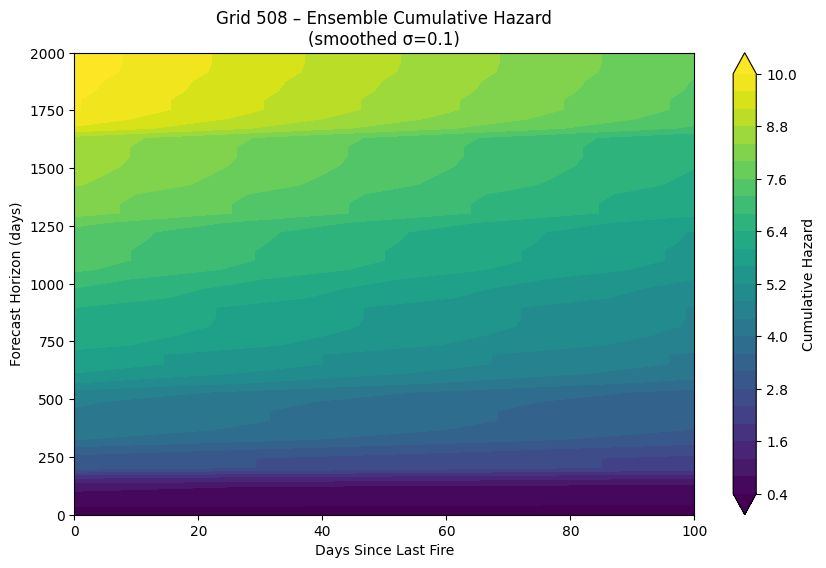

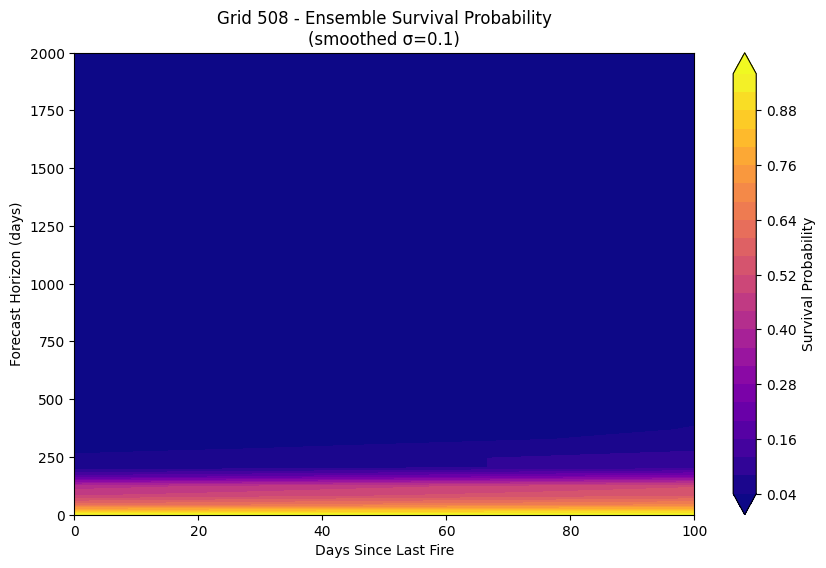

In [33]:
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

def predict_and_plot_with_DeepSurv_ensemble(
    deep_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=5000,
    sigma=0.1,
    delta_t=50
):
    # ranges for axes
    days_since_fire_range = np.arange(0, 101, 5)
    forecast_range       = np.linspace(0, 2000, 50)

    # pre-allocate
    survival_matrix = np.zeros((len(forecast_range), len(days_since_fire_range)))
    hazard_matrix   = np.zeros_like(survival_matrix)

    predictor_vars = deep_models[0]['features']

    for i, forecast_time in enumerate(forecast_range):
        for j, dsf in enumerate(days_since_fire_range):

            cumulative_hazard = 0.0
            time_steps = np.arange(0, forecast_time + delta_t, delta_t)
            prev_H0_val = 0.0

            for t_step in time_steps:

                # recompute weather at this point in time
                month = day_to_month(t_step % 365)
                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

                # build X(t_step)
                row = build_baseline_row(event_df, grid_id)
                row.update(monthly_vars)
                row["days_since_last_fire"] = dsf
                row["cos_month"], row["sin_month"] = compute_seasonality_cos_sin(t_step)

                for var in ["powerline","grass","shrub","agri","slope30","mean_eleva",
                            "no_prior_fire","humidity","wui","temperature","drought20",
                            "forest","road"]:
                    if pd.isna(row.get(var, np.nan)):
                        row[var] = 0.0

                # neighbor features
                row_mod = compute_neighbor_features(
                    row.copy(),
                    deep_models[0]['df_train'],
                    deep_models[0]['coords_train'],
                    deep_models[0]['tree_train'],
                    neighbor_radius
                )
                row_mod["forest_combined"] = (row_mod["forest"] + row_mod["neighbor_forest"]) / 2
                row_mod["road_combined"]   = (row_mod["road"]   + row_mod["neighbor_road"])   / 2
                row_mod["temperature_sq"]  = row_mod["temperature"] ** 2
                row_mod["temp_forest_interaction"] = (
                    row_mod["temperature"] * row_mod["forest_combined"]
                )

                X_temp = pd.DataFrame([row_mod])[predictor_vars]
                X_scaled = deep_models[0]['scaler'].transform(X_temp).astype('float32')
                X_tensor = torch.tensor(X_scaled.astype('float32'), dtype=torch.float32)

                # ensemble predict log hazard → multiplier
                # ensemble predict log partial hazard → multiplier
                multiplier_preds = []
                for mdl in deep_models:
                    log_partial_hazard_array = mdl['model'].predict(X_scaled)
                    log_partial_hazard = log_partial_hazard_array[0]  # first row in batch


                    multiplier_i = np.exp(log_partial_hazard)
                    multiplier_preds.append(multiplier_i)


                avg_multiplier = np.mean(multiplier_preds)

                # interpolate baseline H0(t_step)
                H0_val = np.interp(
                    t_step,
                    mdl['model'].baseline_cumulative_hazards_.index.values,
                    mdl['model'].baseline_cumulative_hazards_.values.flatten(),
                    right=mdl['model'].baseline_cumulative_hazards_.values.flatten()[-1]
                )

                # incremental delta H0
                delta_H0 = H0_val - prev_H0_val
                prev_H0_val = H0_val

                # accumulate hazard
                cumulative_hazard += delta_H0 * avg_multiplier

            # store result
            hazard_matrix[i, j]   = cumulative_hazard
            survival_matrix[i, j] = np.exp(-cumulative_hazard)

    # smooth & plot
    survival_smooth = gaussian_filter(survival_matrix, sigma=sigma)
    hazard_smooth   = gaussian_filter(hazard_matrix,   sigma=sigma)
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(10,6))
    cf = plt.contourf(Xg, Yg, hazard_smooth, levels=30, cmap='viridis', extend='both')
    plt.colorbar(cf, label='Cumulative Hazard')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} – Ensemble Cumulative Hazard\n(smoothed σ={sigma})')
    plt.show()

    plt.figure(figsize=(10,6))
    cf2 = plt.contourf(Xg, Yg, survival_smooth, levels=30, cmap='plasma', extend='both')
    plt.colorbar(cf2, label='Survival Probability')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} - Ensemble Survival Probability\n(smoothed σ={sigma})')
    plt.show()


# call it:
predict_and_plot_with_DeepSurv_ensemble(
    deep_models=deep_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=508,
    statistic='median',
    neighbor_radius=5000,
    sigma=0.1
)



DeepSurv Integrated Brier Score (IBS): 0.1120 ± 0.0170


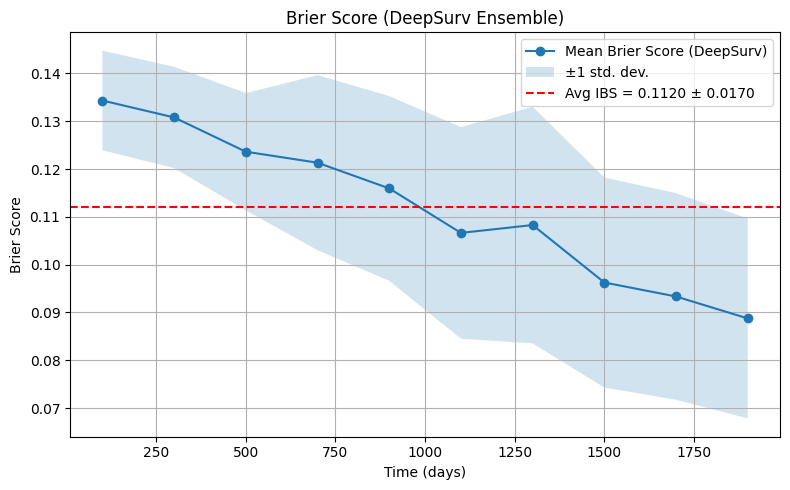

In [131]:
# Stack fold Brier scores: shape = (n_splits, len(eval_times))
brier_matrix = np.stack(all_brier_scores_deepsurv)

# Mean and std Brier score curve
mean_bs = brier_matrix.mean(axis=0)
std_bs = brier_matrix.std(axis=0, ddof=1)

# Integrated Brier Score (IBS) per fold
ibs_per_fold = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix
]
ibs_mean = np.mean(ibs_per_fold)
ibs_std = np.std(ibs_per_fold, ddof=1)

print(f"\nDeepSurv Integrated Brier Score (IBS): {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score (DeepSurv)")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (DeepSurv Ensemble)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Number of calibration records: 25


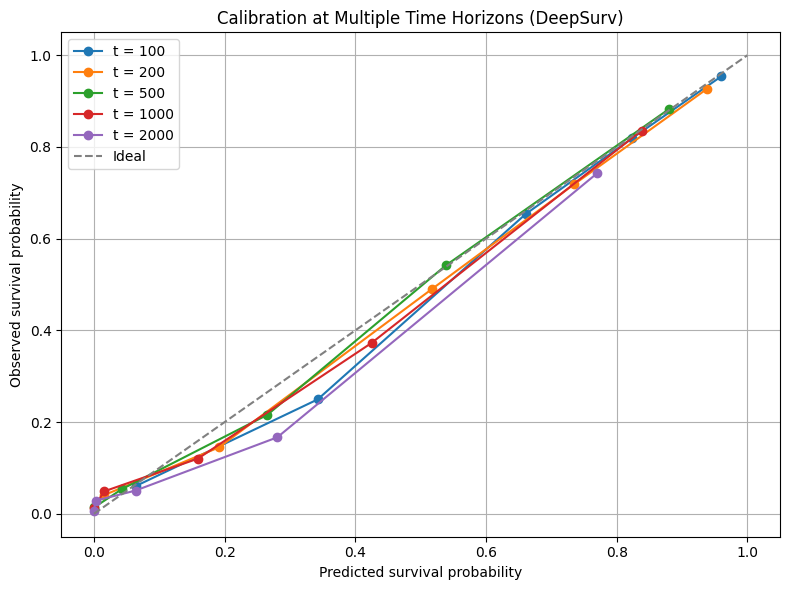

In [135]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

cal_records = []

# For each horizon, collect _all_ preds + outcomes across folds
for t in time_horizons:
    rows = []
    for fold in deep_models:
        # predict survival at t for this fold
        surv_df = fold["model"].predict_surv_df(fold["X_test"].astype("float32"))

        preds_t = np.array([
            np.interp(t, surv_df.index.values, surv_df.iloc[:, i].values)
            for i in range(surv_df.shape[1])
        ])

        # assemble a small DataFrame of this fold's results
        df_f = pd.DataFrame({
        "duration": fold["y_test"]["duration"],
        "event":    fold["y_test"]["fire_occurred_x"],
        "pred":     preds_t
        })

        rows.append(df_f)

    # pool them
    df_all = pd.concat(rows, ignore_index=True)

    # single q‐cut on the pooled preds
    df_all["bin"] = pd.qcut(df_all["pred"], q=n_bins, labels=False, duplicates="drop")

    kmf = KaplanMeierFitter()
    # compute one set of bin‐level pred/obs
    for b in sorted(df_all["bin"].unique()):
        sub = df_all[df_all["bin"] == b]
        if len(sub) < 5:
            continue
        mean_pred = sub["pred"].mean()
        kmf.fit(sub["duration"], sub["event"])
        obs_surv = kmf.predict(t)
        cal_records.append({
            "time": t,
            "pred": mean_pred,
            "obs":  obs_surv
        })

# turn into DataFrame & plot
print(f"Number of calibration records: {len(cal_records)}")

df_cal = pd.DataFrame(cal_records)

plt.figure(figsize=(8, 6))
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (DeepSurv)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


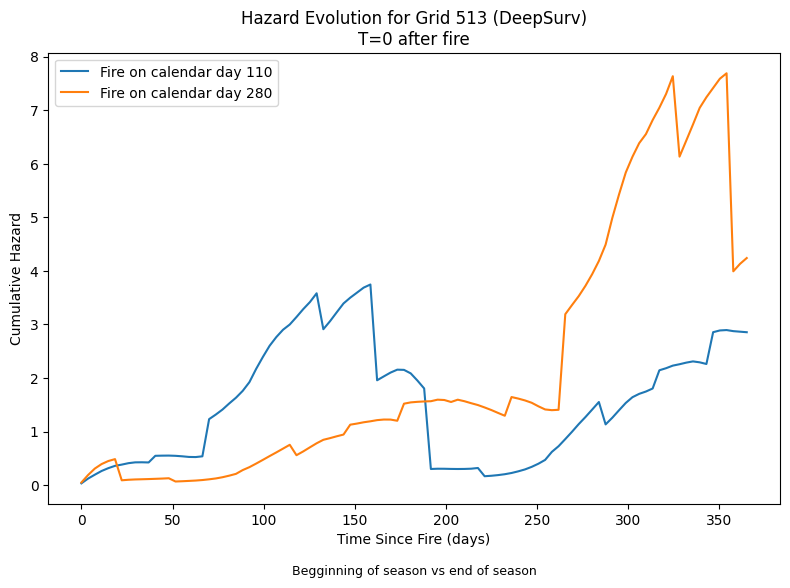

In [ ]:
def compare_fire_timing_effect_deepsurv(deep_model, df_train, coords_train, tree_train, 
                                        event_df, df_monthly, grid_id, 
                                        initial_day_values=[120, 300], forecast_horizon=365,
                                        days_since_fire=0, neighbor_radius=5000, statistic='median'):
    """
    Compare cumulative hazard evolution for a grid cell using a DeepSurv model
    when fire occurs at different calendar days, with seasonality (sin/cos month).
    """

    rsf_features = deep_model["features"]
    scaler = deep_model["scaler"]

    forecast_times = np.linspace(0, forecast_horizon, 100)
    results = {}
    baseline = build_baseline_row(event_df, grid_id)

    def compute_seasonality_cos_sin(t_days):
        cos_month = np.cos(2 * np.pi * (t_days % 365) / 365)
        sin_month = np.sin(2 * np.pi * (t_days % 365) / 365)
        return cos_month, sin_month

    for init_day in initial_day_values:
        hazard_curve = []
        for t in forecast_times:
            effective_day = (init_day + t) % 365
            month = day_to_month(effective_day)
            monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

            row = baseline.copy()
            row["days_since_last_fire"] = days_since_fire

            # Add seasonal features
            cos_month, sin_month = compute_seasonality_cos_sin(init_day + t)
            row["cos_month"] = cos_month
            row["sin_month"] = sin_month

            # Add monthly variables
            row.update(monthly_vars)

            # Ensure required base variables are present
            for var in ["powerline", "grass", "shrub", "agri", "slope30", "mean_eleva", "no_prior_fire"]:
                if var not in row:
                    row[var] = baseline.get(var, 0.0)

            # Add neighbor features
            row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)

            # === 🔧 Feature Engineering (MUST match training logic) ===
            row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
            row["road_combined"] = (row["road"] + row["neighbor_road"]) / 2
            row["temperature_sq"] = row["temperature"] ** 2
            row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]
            # Optional: interaction term if used
            if "dsf_x_no_prior" in rsf_features:
                row["dsf_x_no_prior"] = row["days_since_last_fire"] * row.get("no_prior_fire", 0.0)

            # === Assemble input ===
            X_temp = pd.DataFrame([row])
            missing = [f for f in rsf_features if f not in X_temp.columns]
            if missing:
                print(f"Warning: Missing features for prediction: {missing}")
                for m in missing:
                    X_temp[m] = 0.0  # or set a fallback value

            X_temp = X_temp[rsf_features]

            X_scaled = pd.DataFrame(
                scaler.transform(X_temp),
                columns=rsf_features
            )

            # Predict survival using DeepSurv
            surv_df = deep_model["model"].predict_surv_df(X_scaled.values.astype("float32"))
            t_effective = min(t, surv_df.index[-1])
            surv_prob = np.interp(t_effective, surv_df.index.values, surv_df.iloc[:, 0].values)

            epsilon = 1e-6
            surv_prob_safe = np.clip(surv_prob, epsilon, 1.0)
            hazard = -np.log(surv_prob_safe)
            hazard_curve.append(hazard)

        results[init_day] = hazard_curve

    # === Plot ===
    plt.figure(figsize=(8, 6))
    for init_day, hazard_curve in results.items():
        plt.plot(forecast_times, hazard_curve, label=f'Fire on calendar day {init_day}')
    plt.xlabel("Time Since Fire (days)")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id} (DeepSurv)\nT=0 after fire")
    plt.legend()

    annotation = ("Begginning of season vs end of season")
    plt.annotate(annotation, xy=(0.5, -0.15), xycoords='axes fraction', fontsize=9,
                 ha='center', va='center')
    plt.tight_layout()
    plt.show()
compare_fire_timing_effect_deepsurv(
    deep_model=deep_models[0],  # pick a trained DeepSurv fold
    df_train=deep_models[0]["df_train"],
    coords_train=deep_models[0]["coords_train"],
    tree_train=deep_models[0]["tree_train"],
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=513,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    statistic='median'
)


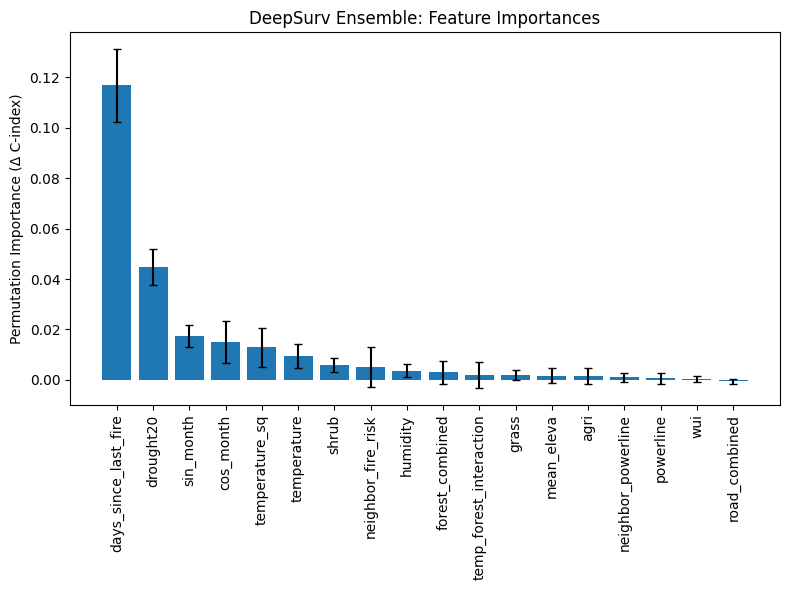

In [29]:
# corrected permutation importance for DeepSurv ensemble
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# 1) feature names (from the first fold's metadata)
features = deep_models[0]["features"]

# 2) scorer that handles both numpy arrays and DataFrames
def dsf_scorer(estimator, X, y_struct):
    # structured array field names
    event_name, time_name = y_struct.dtype.names
    # extract numeric array
    if isinstance(X, pd.DataFrame):
        X_arr = X.values.astype("float32")
    else:
        X_arr = X.astype("float32")
    # DeepSurv.predict returns an array of shape (n_samples,)
    scores = estimator.predict(X_arr).ravel()
    return concordance_index_censored(
        y_struct[event_name], y_struct[time_name], scores
    )[0]

all_imps = []
# 3) loop over folds
for fold_idx, fold in enumerate(deep_models, 1):
    mdl = fold["model"]
    X_test = fold["X_test"]       # numpy array, shape (n_samples, n_features)
    y_test = fold["y_test"]       # structured array with fields ('event','time')
    
    n_samples = X_test.shape[0]
    # subsample up to 500 rows for speed
    if n_samples > 1000:
        rng = np.random.RandomState(0)
        idx = rng.choice(n_samples, size=1000, replace=False)
        X_sub = X_test[idx]
        y_sub = y_test[idx]
    else:
        X_sub, y_sub = X_test, y_test

    # compute permutation importance for this fold
    res = permutation_importance(
        estimator=mdl,
        X=X_sub,
        y=y_sub,
        scoring=dsf_scorer,
        n_repeats=3,
        random_state=42,
        n_jobs=1
    )
    all_imps.append(res.importances_mean)

# 4) aggregate over folds
imp_mat  = np.vstack(all_imps)           # shape (n_folds, n_features)
mean_imp = imp_mat.mean(axis=0)
std_imp  = imp_mat.std(axis=0)

feat_imp = (
    pd.DataFrame({
        "feature":         features,
        "mean_importance": mean_imp,
        "std_importance":  std_imp
    })
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

# 5) plot
plt.figure(figsize=(8,6))
plt.bar(
    feat_imp["feature"],
    feat_imp["mean_importance"],
    yerr=feat_imp["std_importance"],
    capsize=3
)
plt.xticks(rotation=90)
plt.ylabel("Permutation Importance (Δ C-index)")
plt.title("DeepSurv Ensemble: Feature Importances")
plt.tight_layout()
plt.show()


In [21]:
# assuming your full dataset is in `df_model` (or replace with the appropriate DataFrame)

# 1) build the mask
leak_mask = df_model["days_since_last_fire"] == df_model["duration"]

# 2) total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == duration: {n_leak}")

# 3) breakdown of fire_occurred_x in those rows
vc = df_model.loc[leak_mask, "fire_occurred_x"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)


Number of rows where days_since_last_fire == duration: 7775
fire_occurred_x value counts among those rows:
fire_occurred_x
0    2810
1    4965
Name: count, dtype: int64


In [22]:
leak_mask = df_model["days_since_last_fire"] == 1

# 2) total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == 1: {n_leak}")

# 3) breakdown of fire_occurred_x in those rows
vc = df_model.loc[leak_mask, "fire_occurred_x"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)


Number of rows where days_since_last_fire == 1: 1902
fire_occurred_x value counts among those rows:
fire_occurred_x
0     667
1    1235
Name: count, dtype: int64


In [49]:
len(event_df)

9924

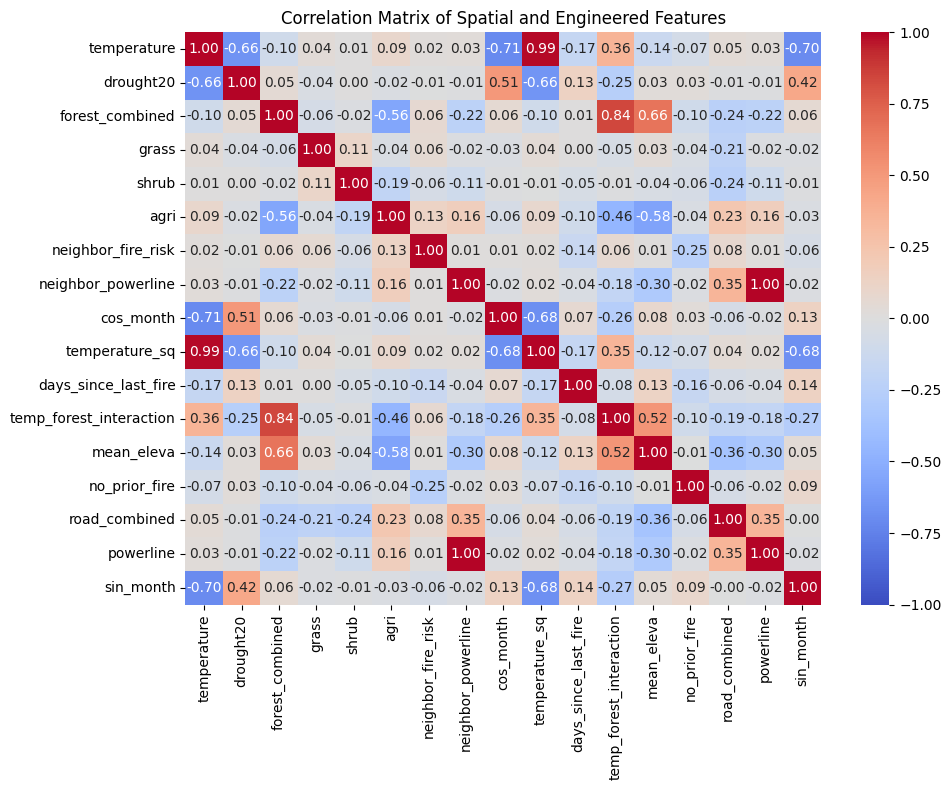

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features
corr_features = [
    "temperature", "drought20", "forest_combined", "grass", "shrub", "agri",
    "neighbor_fire_risk", "neighbor_powerline",
    "cos_month", "temperature_sq", "days_since_last_fire",
    "temp_forest_interaction", "mean_eleva", "no_prior_fire", "road_combined", "powerline", "sin_month"
]

# Compute correlation matrix
corr_matrix = df_train[corr_features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Spatial and Engineered Features")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import numpy as np
import pandas as pd

# --- Base and candidate features ---
base_features = [
    "temperature", "wind_speed", "drought20", "forest_combined", "grass", "shrub", "agri",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline", "neighbor_ERI",
    "cos_month", "sin_month", "mean_eleva", "no_prior_fire", "road_combined", "powerline", "humidity"
]

# New features to test
df_train["forest_diff"] = df_train["forest"] - df_train["neighbor_forest"]
df_train["log_drought20"] = np.log1p(df_train["drought20"])
df_train["cos_wind_interaction"] = df_train["cos_month"] * df_train["wind_speed"]
df_train["eleva_drought_interaction"] = df_train["mean_eleva"] * df_train["drought20"]
df_train["no_prior_x_neighbor_risk"] = df_train["no_prior_fire"] * df_train["neighbor_fire_risk"]
df_train["shrubsq"] = df_train["shrub"] ** 2
df_train["log_neighbor_powerline"] = np.log1p(df_train["neighbor_powerline"])

candidate_features = [
    "forest_diff", "log_drought20", "cos_wind_interaction",
    "eleva_drought_interaction", "no_prior_x_neighbor_risk",
    "shrubsq", "log_neighbor_powerline"
]


# --- Scale + split ---
all_features = list(set(base_features + candidate_features))
X_all = df_train[all_features].astype("float32")
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=all_features)

durations = df_train["duration"].astype("float32").values
events = df_train["fire_occurred_x"].astype(int).astype("float32").values

X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
    X_scaled, durations, events, test_size=0.2, random_state=42
)

# --- Run loop ---
results = []
for feature in [None] + candidate_features:
    if feature is None:
        feats = base_features
        label = "Base only"
    else:
        feats = base_features + [feature]
        label = f"+ {feature}"

    X_tr = X_train[feats].values
    X_va = X_val[feats].values

    net = tt.practical.MLPVanilla(
        in_features=X_tr.shape[1], num_nodes=[32], out_features=1,
        activation=torch.nn.ReLU, dropout=0.2
    )
    model = CoxPH(net, tt.optim.Adam)
    model.fit(X_tr, (durations_train, events_train), batch_size=64, epochs=100, verbose=False)

    model.compute_baseline_hazards()
    surv_df = model.predict_surv_df(X_va)
    ev = EvalSurv(surv_df, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td("antolini")
    results.append((label, c_index))


# --- Display leaderboard ---
leaderboard = pd.DataFrame(results, columns=["Feature_Set", "C-index"]).sort_values(by="C-index", ascending=False)
print(leaderboard)


                   Feature_Set   C-index
6                    + shrubsq  0.708742
7     + log_neighbor_powerline  0.707395
5   + no_prior_x_neighbor_risk  0.704821
3       + cos_wind_interaction  0.704820
4  + eleva_drought_interaction  0.703019
1                + forest_diff  0.702514
0                    Base only  0.700348
2              + log_drought20  0.698952


In [111]:

#####################################################
# 3. PREDICTION & CONTOUR PLOTTING
#####################################################
def compute_seasonality_cos_sin(t_days):
    cos_month = np.cos(2 * np.pi * (t_days % 365) / 365)
    sin_month = np.sin(2 * np.pi * (t_days % 365) / 365)
    return cos_month, sin_month


def predict_and_plot_with_deepsurv(model_deep, df_train, coords_train, tree_train, scaler,
                                   event_df, df_summary_monthly, grid_id, statistic='median',
                                   neighbor_radius=5000, sigma=0.5):
    """
    Generates contour plots with:
      - x-axis: days since last fire (0 to 100)
      - y-axis: forecast horizon (in days)
    using the DeepSurv model (model_deep). For each combination, a predictor row is assembled,
    scaled, and the survival probability at the forecast time is interpolated to compute the cumulative hazard.
    """
    # These lists must match your training:
    rsf_features = [
        "temperature", "wind_speed", "drought20", "forest_combined", "grass", "shrub", "agri",
        "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline", "neighbor_ERI",
        "cos_month", "temperature_sq", "wind_speed_sq",
        "temp_forest_interaction", "mean_eleva", "no_prior_fire", "road_combined", "powerline", "sin_month", "humidity"
    ]
    cols_to_scale = ["temperature", "wind_speed", "drought20", "powerline", "forest_combined",
                 "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
                 "neighbor_ERI", "grass", "shrub", "agri", "mean_eleva", "road_combined", "humidity"]
    
    # Derived features: (these were computed on the raw row)
    derived_features = ["temperature_sq", "wind_speed_sq", "temp_forest_interaction",
                        "cos_month", "no_prior_fire"]
    
    # Define grid ranges:
    dsf_range = np.arange(0, 101, 5)             # x-axis: DSF from 0 to 100
    forecast_range = np.linspace(0, 2000, 40)      # y-axis: forecast horizon (days)
    
    survival_matrix = np.zeros((len(forecast_range), len(dsf_range)))
    hazard_matrix = np.zeros((len(forecast_range), len(dsf_range)))
    
    # Build fixed baseline row for grid_id using fixed covariates
    baseline = build_baseline_row(event_df, grid_id)
    
    for i, forecast_time in enumerate(forecast_range):
        month = day_to_month(forecast_time % 365)
        monthly_vars = get_monthly_values(df_summary_monthly, grid_id, month, stat=statistic)
        for j, dsf in enumerate(dsf_range):
            row = baseline.copy()
            row["days_since_last_fire"] = dsf
            cos_month, sin_month = compute_seasonality_cos_sin(forecast_time)
            row["cos_month"] = cos_month
            row["sin_month"] = sin_month

            row.update(monthly_vars)
            # Ensure required fixed covariates are present:
            for var in ["powerline", "grass", "shrub", "agri", "mean_eleva", "no_prior_fire"]:
                if var not in row:
                    row[var] = baseline.get(var, 0.0)
            # Compute neighbor features for this row:
            row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
            # Compute combined and derived features:
            row["forest_combined"] = (row["forest"] + row.get("neighbor_forest", row["forest"])) / 2
            row["road_combined"] = (row["road"] + row.get("neighbor_road", row["road"])) / 2
            row["temperature_sq"] = row["temperature"] ** 2
            row["wind_speed_sq"] = row["wind_speed"] ** 2
            row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]
            
            # Build one-row DataFrame and apply scaling:
            # Build one-row DataFrame and apply scaling:
            X_temp = pd.DataFrame([row])

# Scale:
            X_scaled_full = X_temp.copy()
            X_scaled_full[cols_to_scale] = scaler.transform(X_temp[cols_to_scale])

            # Derived features after scaling:
            X_scaled_full["temperature_sq"] = X_scaled_full["temperature"] ** 2
            X_scaled_full["wind_speed_sq"] = X_scaled_full["wind_speed"] ** 2
            X_scaled_full["temp_forest_interaction"] = X_scaled_full["temperature"] * X_scaled_full["forest_combined"]
            X_scaled_full["dsf_x_no_prior"] = X_scaled_full["days_since_last_fire"] * X_scaled_full["no_prior_fire"]

            # Add non-scaled, pre-computed features:
            X_scaled_full["cos_month"] = X_temp["cos_month"].values
            X_scaled_full["no_prior_fire"] = X_temp["no_prior_fire"].values

            # Ensure columns are correctly ordered:
            X_final = X_scaled_full[rsf_features].astype(np.float32)

            # Now make predictions:
            surv_df = model_deep.predict_surv_df(X_final)


            time_idx = surv_df.index.values
            surv_curve = surv_df.iloc[:, 0].values
            # Interpolate survival probability at the forecast_time:
            if forecast_time <= time_idx[0]:
                surv_prob = surv_curve[0]
            elif forecast_time >= time_idx[-1]:
                surv_prob = surv_curve[-1]
            else:
                surv_prob = np.interp(forecast_time, time_idx, surv_curve)
            survival_matrix[i, j] = surv_prob
            hazard_matrix[i, j] = -np.log(surv_prob) if surv_prob > 0 else np.nan
            
    # Smooth with a Gaussian filter:
    survival_matrix_smoothed = gaussian_filter(survival_matrix, sigma=sigma)
    hazard_matrix_smoothed = gaussian_filter(hazard_matrix, sigma=sigma)
    
    # Create meshgrid for plotting:
    X_plot, Y_plot = np.meshgrid(dsf_range, forecast_range)
    
    # Plot cumulative hazard:
    plt.figure(figsize=(10,6))
    cp1 = plt.contourf(X_plot, Y_plot, hazard_matrix_smoothed, levels=30, extend="both")
    plt.colorbar(cp1, label="Cumulative Hazard (Smoothed)")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"DeepSurv Predicted Cumulative Hazard\n(Grid {grid_id}, {statistic.capitalize()} Conditions, σ={sigma})")
    plt.xlim(dsf_range[0], dsf_range[-1])
    plt.show()
    
    # Plot survival probability:
    plt.figure(figsize=(10,6))
    cp2 = plt.contourf(X_plot, Y_plot, survival_matrix_smoothed, levels=30, extend="both")
    plt.colorbar(cp2, label="Survival Probability (Smoothed)")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"DeepSurv Predicted Survival Probability\n(Grid {grid_id}, {statistic.capitalize()} Conditions, σ={sigma})")
    plt.xlim(dsf_range[0], dsf_range[-1])
    plt.show()

# Example usage for grid 7 (change grid_id and statistic as needed):
predict_and_plot_with_deepsurv(model_deep, df_train, coords_train, tree_train, scaler,
                               event_df, df_monthly, grid_id=513,
                               statistic='median', neighbor_radius=5000, sigma=0.5)


NameError: name 'model_deep' is not defined

In [9]:
from scipy.stats import wilcoxon

# AG Model
ag_test = [0.7704, 0.7980, 0.7793, 0.8170, 0.8292, 0.8240, 0.7941]

# RSF Model
rsf_test = [0.7711, 0.8174, 0.8035, 0.8318, 0.8433, 0.8545, 0.8136]

# DeepSurv Model
ds_test = [0.7929, 0.8304, 0.8140, 0.8349, 0.8596, 0.8614, 0.8215]

# Wilcoxon test: RSF vs AG
stat_rsf_ag, p_rsf_ag = wilcoxon(rsf_test, ag_test)
# RSF vs DeepSurv
stat_rsf_ds, p_rsf_ds = wilcoxon(rsf_test, ds_test)
# DeepSurv vs AG
stat_ds_ag, p_ds_ag = wilcoxon(ds_test, ag_test)

print("RSF vs AG p-value:", p_rsf_ag)
print("RSF vs DeepSurv p-value:", p_rsf_ds)
print("DeepSurv vs AG p-value:", p_ds_ag)


RSF vs AG p-value: 0.015625
RSF vs DeepSurv p-value: 0.015625
DeepSurv vs AG p-value: 0.015625


In [ ]:
import numpy as np

# AG Model
ag_test = [0.7704, 0.7980, 0.7793, 0.8170, 0.8292, 0.8240, 0.7941]

# RSF Model
rsf_test = [0.7711, 0.8174, 0.8035, 0.8318, 0.8433, 0.8545, 0.8136]

# DeepSurv Model
ds_test = [0.7929, 0.8304, 0.8140, 0.8349, 0.8596, 0.8614, 0.8215]

def bootstrap_ci_diff(a, b, n_boot=5000, ci=95):
    diffs = np.array(a) - np.array(b)
    boot_means = []
    for _ in range(n_boot):
        idxs = np.random.randint(0, len(diffs), size=len(diffs))
        boot_means.append(diffs[idxs].mean())
    lower, upper = np.percentile(boot_means, [(100-ci)/2, 100-(100-ci)/2])
    return lower, upper

# RSF vs AG
ci_rsf_ag = bootstrap_ci_diff(rsf_test, ag_test)
# DeepSurv vs AG
ci_ds_ag  = bootstrap_ci_diff(ds_test, ag_test)
# RSF vs DeepSurv
ci_rsf_ds = bootstrap_ci_diff(rsf_test, ds_test)

print(f"95% CI for (RSF - AG) ΔC-index: [{ci_rsf_ag[0]:.3f}, {ci_rsf_ag[1]:.3f}]")
print(f"95% CI for (DeepSurv - AG) ΔC-index: [{ci_ds_ag[0]:.3f}, {ci_ds_ag[1]:.3f}]")
print(f"95% CI for (RSF - DeepSurv) ΔC-index: [{ci_rsf_ds[0]:.3f}, {ci_rsf_ds[1]:.3f}]")


95% CI for (RSF – AG) ΔC-index: [0.011, 0.024]
95% CI for (DeepSurv – AG) ΔC-index: [0.024, 0.033]
95% CI for (RSF – DeepSurv) ΔC-index: [-0.016, -0.007]


In [12]:
from scipy.stats import shapiro, ttest_rel, wilcoxon

# AG Model
ag= [0.7704, 0.7980, 0.7793, 0.8170, 0.8292, 0.8240, 0.7941]

# RSF Model
rsf = [0.7711, 0.8174, 0.8035, 0.8318, 0.8433, 0.8545, 0.8136]

# DeepSurv Model
ds = [0.7929, 0.8304, 0.8140, 0.8349, 0.8596, 0.8614, 0.8215]

# 1) Compute paired differences
diff_rsf_ag  = [r - a for r, a in zip(rsf, ag)]
diff_ds_ag   = [d - a for d, a in zip(ds, ag)]
diff_rsf_ds  = [r - d for r, d in zip(rsf, ds)]

# 2) Shapiro–Wilk test for normality of the differences
for name, diffs in [("RSF–AG", diff_rsf_ag),
                    ("DeepSurv–AG", diff_ds_ag),
                    ("RSF–DeepSurv", diff_rsf_ds)]:
    stat, p = shapiro(diffs)
    print(f"{name} normality: W={stat:.3f}, p={p:.3f}")

# 3) Paired t-tests
stat, p = ttest_rel(rsf, ag)
print(f"RSF vs AG paired t-test: t={stat:.3f}, p={p:.4f}")
stat, p = ttest_rel(ds, ag)
print(f"DeepSurv vs AG paired t-test: t={stat:.3f}, p={p:.4f}")
stat, p = ttest_rel(rsf, ds)
print(f"RSF vs DeepSurv paired t-test: t={stat:.3f}, p={p:.4f}")

# 4) Wilcoxon signed-rank tests (two-sided)
stat, p = wilcoxon(rsf, ag)
print(f"RSF vs AG Wilcoxon: W={stat}, p={p:.4f}")
stat, p = wilcoxon(ds, ag)
print(f"DeepSurv vs AG Wilcoxon: W={stat}, p={p:.4f}")
stat, p = wilcoxon(rsf, ds)
print(f"RSF vs DeepSurv Wilcoxon: W={stat}, p={p:.4f}")


RSF–AG normality: W=0.951, p=0.739
DeepSurv–AG normality: W=0.963, p=0.843
RSF–DeepSurv normality: W=0.978, p=0.948
RSF vs AG paired t-test: t=4.990, p=0.0025
DeepSurv vs AG paired t-test: t=11.124, p=0.0000
RSF vs DeepSurv paired t-test: t=-4.782, p=0.0031
RSF vs AG Wilcoxon: W=0.0, p=0.0156
DeepSurv vs AG Wilcoxon: W=0.0, p=0.0156
RSF vs DeepSurv Wilcoxon: W=0.0, p=0.0156
